In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Domain Size: 1.0x1.0
Grid: 81x81
dx=0.0125, dy=0.0125, cell_area=0.000156
Diffusion Coeff: 0.01
Decay Constants: k_P=2.00, k_D=0.40
Calculated Stable dt estimate: 0.003516
Using dt: 0.003516
Total time steps: 284
Saving snapshots at steps: [0, 57, 114, 171, 228]
Snapshot saved for t = 0.000, Mass_P=0.0000e+00, Mass_D=0.0000e+00
Snapshot saved for t = 0.200, Mass_P=1.7955e-02, Mass_D=2.6173e-03
Snapshot saved for t = 0.401, Mass_P=2.5591e-02, Mass_D=8.2943e-03
Snapshot saved for t = 0.601, Mass_P=3.0484e-02, Mass_D=1.5650e-02
Snapshot saved for t = 0.802, Mass_P=3.3708e-02, Mass_D=2.3872e-02

Simulation finished.
Total GPU calculation time: 0.370 seconds


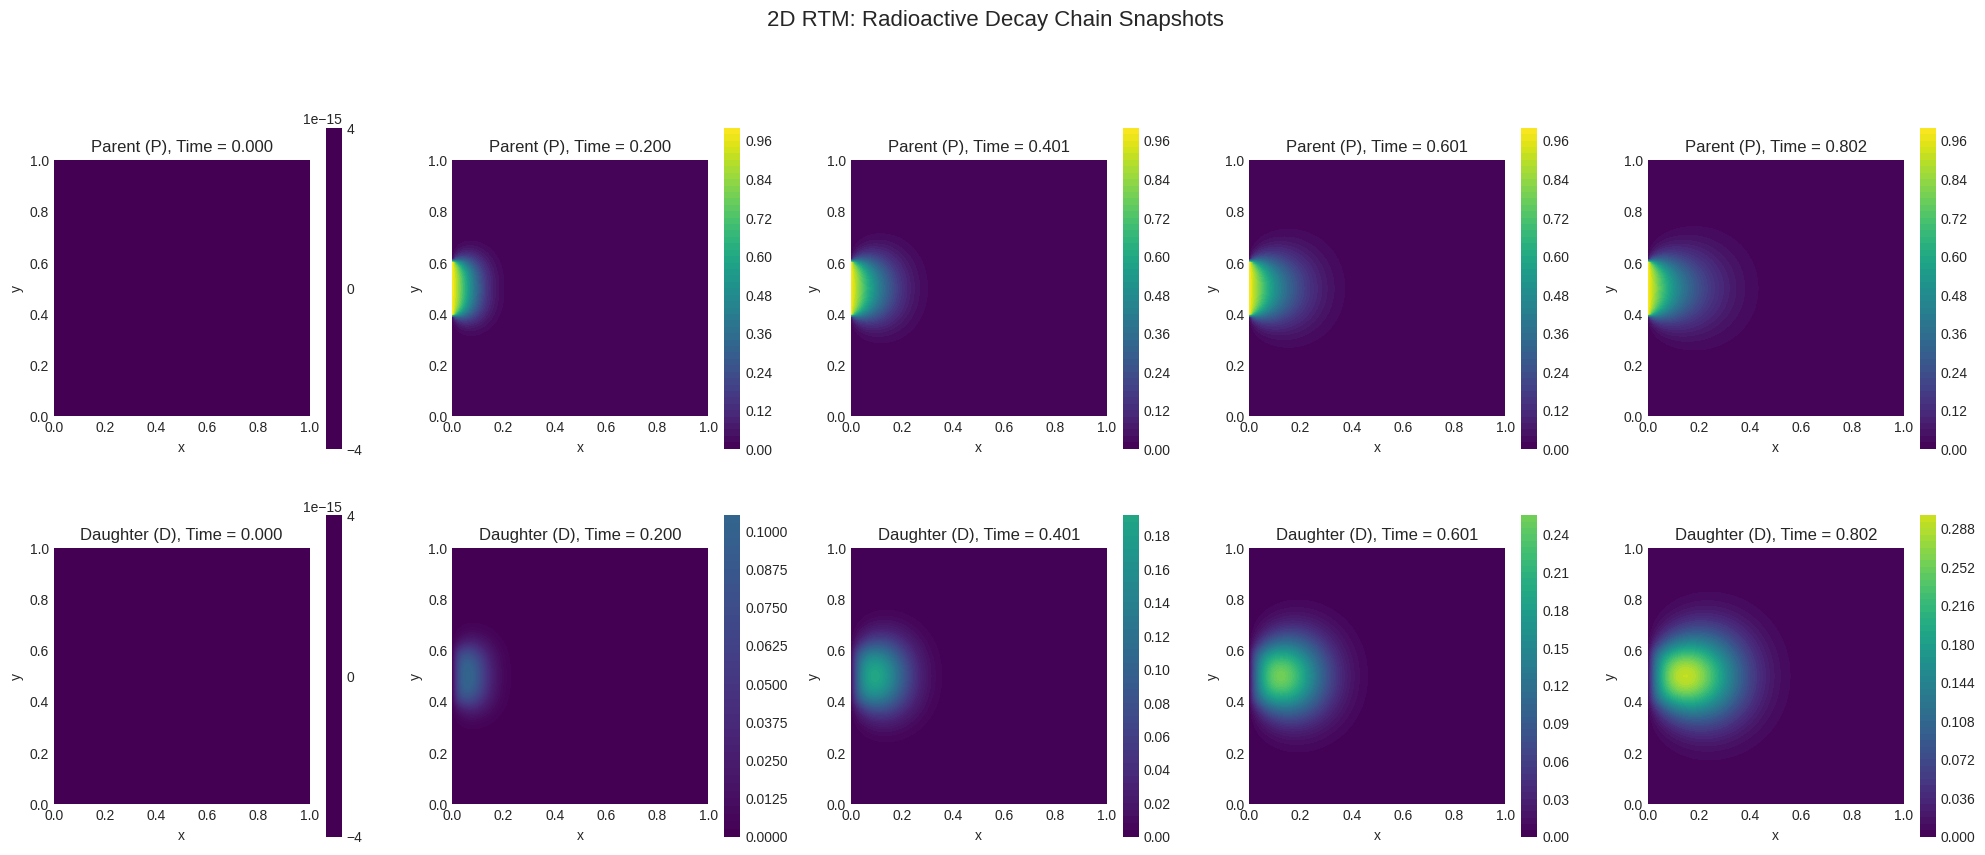

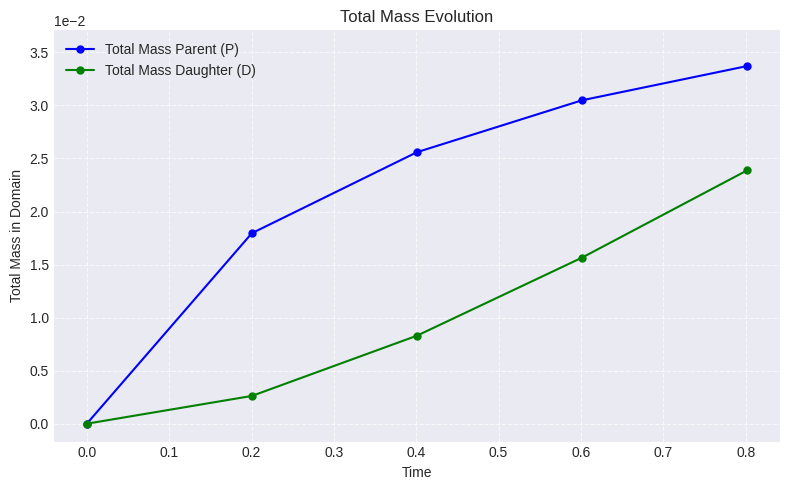

In [11]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import gc # Import garbage collector

# -- Parameters --
# Domain and Grid
L = 1.0          # Domain size (square domain L x L)
Nx = 81         # Number of grid points in x
Ny = 81         # Number of grid points in y
dx = L / (Nx - 1)  # Grid spacing in x
dy = L / (Ny - 1)  # Grid spacing in y
cell_area = dx * dy # Area of one grid cell

# Physics
vx = 0.3         # Flow velocity in x [L/T] (Pore velocity)
vy = 0         # Flow velocity in y [L/T] (Pore velocity)
Diff_coeff = 0.01 # RENAMED Dispersion coefficient [L^2/T] (Same for P and D)
k_P = 2        # Decay rate constant for Parent P [1/T]
k_D = 0.4        # Decay rate constant for Daughter D [1/T]

# Inlet Boundary
P_in = 1.0        # Inlet concentration of Parent P [Concentration Unit]
y_in_frac_start = 0.4 # Fraction of inlet boundary start (from bottom)
y_in_frac_end = 0.6   # Fraction of inlet boundary end (from bottom)

# Simulation Time
t_final = 1.0    # Total simulation time [T] - Reduced back to 1.0 for faster run

# Plotting
num_snapshots = 6 # Number of snapshots to save

# -- Stability Check (Crucial for Explicit Euler) --
max_dt_diff = 0.5 / (Diff_coeff/dx**2 + Diff_coeff/dy**2 + 1e-9)
max_dt_adv_x = dx / (abs(vx) + 1e-9)
max_dt_adv_y = dy / (abs(vy) + 1e-9) # Will be large if vy=0
max_dt_adv = 0.5 * min(max_dt_adv_x, max_dt_adv_y)
max_dt_react = 0.5 / (max(k_P, k_D) + 1e-9)

dt_stable = 0.9 * min(max_dt_diff, max_dt_adv, max_dt_react) # Use 90% for safety
# dt = dt_stable * 0.5 # Make it smaller if needed
dt = dt_stable

n_steps = int(t_final / dt)
# Ensure n_steps is reasonable
if n_steps <= 0:
    raise ValueError("Calculated n_steps is zero or negative. Check t_final and dt.")
if n_steps > 1e7: # Safety break
    print(f"Warning: Very large number of steps ({n_steps}). Consider increasing dt or decreasing t_final.")


print(f"Domain Size: {L}x{L}")
print(f"Grid: {Nx}x{Ny}")
print(f"dx={dx:.4f}, dy={dy:.4f}, cell_area={cell_area:.6f}")
print(f"Diffusion Coeff: {Diff_coeff}")
print(f"Decay Constants: k_P={k_P:.2f}, k_D={k_D:.2f}")
print(f"Calculated Stable dt estimate: {dt_stable:.6f}")
print(f"Using dt: {dt:.6f}")
print(f"Total time steps: {n_steps}")

# Calculate steps at which to save snapshots
snap_times_target = np.linspace(0, t_final, num_snapshots)
snapshot_indices = np.unique(np.round(snap_times_target / dt).astype(int)).tolist()
if n_steps - 1 not in snapshot_indices and n_steps - 1 > 0:
     if not snapshot_indices or n_steps-1 > snapshot_indices[-1]:
          snapshot_indices.append(n_steps - 1)
snapshot_indices = sorted([idx for idx in snapshot_indices if 0 <= idx < n_steps])
if 0 not in snapshot_indices:
     snapshot_indices.insert(0,0)

print(f"Saving snapshots at steps: {snapshot_indices}")

# -- Initialization on GPU using CuPy --
P = cp.zeros((Ny, Nx), dtype=cp.float64)
D_conc = cp.zeros((Ny, Nx), dtype=cp.float64) # Renamed Daughter array

# Get inlet boundary indices
j_in_start = int(y_in_frac_start * (Ny - 1))
j_in_end = int(y_in_frac_end * (Ny - 1))

# Lists to store results for plotting (on CPU)
results_P_to_plot = []
results_D_to_plot = []
times_to_plot = []
# Lists to store total mass
total_mass_P = []
total_mass_D = []

# --- Calculate and Save Initial State & Mass ---
current_time = 0.0
if 0 in snapshot_indices:
    P_cpu = P.get().copy()
    D_cpu = D_conc.get().copy()
    results_P_to_plot.append(P_cpu)
    results_D_to_plot.append(D_cpu)
    times_to_plot.append(current_time)
    # Initial mass calculation (Sum concentration * cell_area)
    mass_P_t0 = cp.sum(P).item() * cell_area
    mass_D_t0 = cp.sum(D_conc).item() * cell_area
    total_mass_P.append(mass_P_t0)
    total_mass_D.append(mass_D_t0)
    print(f"Snapshot saved for t = {current_time:.3f}, Mass_P={mass_P_t0:.4e}, Mass_D={mass_D_t0:.4e}")


# -- Time Stepping Loop (GPU Accelerated) --
start_time = time.time()

for n in range(n_steps):
    P_old = P.copy()
    D_old = D_conc.copy()

    # --- Finite Difference Calculations for Internal Nodes ---
    # Calculate Laplacian Explicitly
    d2P_dx2 = (P_old[1:-1, 2:  ] - 2 * P_old[1:-1, 1:-1] + P_old[1:-1, 0:-2]) / dx**2
    d2P_dy2 = (P_old[2:  , 1:-1] - 2 * P_old[1:-1, 1:-1] + P_old[0:-2, 1:-1]) / dy**2
    lap_P = d2P_dx2 + d2P_dy2

    d2D_dx2 = (D_old[1:-1, 2:  ] - 2 * D_old[1:-1, 1:-1] + D_old[1:-1, 0:-2]) / dx**2
    d2D_dy2 = (D_old[2:  , 1:-1] - 2 * D_old[1:-1, 1:-1] + D_old[0:-2, 1:-1]) / dy**2
    lap_D = d2D_dx2 + d2D_dy2

    # Calculate Advection Explicitly (Upwind vx>0, vy=0)
    dP_dx = (P_old[1:-1, 1:-1] - P_old[1:-1, 0:-2]) / dx
    #dP_dy = (P_old[1:-1, 1:-1] - P_old[0:-2, 1:-1]) / dy # Not needed if vy=0
    adv_P = vx * dP_dx

    dD_dx = (D_old[1:-1, 1:-1] - D_old[1:-1, 0:-2]) / dx
    #dD_dy = (D_old[1:-1, 1:-1] - D_old[0:-2, 1:-1]) / dy # Not needed if vy=0
    adv_D = vx * dD_dx

    # --- Update Equations (Explicit Euler) ---
    P[1:-1, 1:-1] = P_old[1:-1, 1:-1] + dt * (Diff_coeff * lap_P - adv_P - k_P * P_old[1:-1, 1:-1])
    D_conc[1:-1, 1:-1] = D_old[1:-1, 1:-1] + dt * (Diff_coeff * lap_D - adv_D + k_P * P_old[1:-1, 1:-1] - k_D * D_old[1:-1, 1:-1])

    # Clip
    P = cp.maximum(0.0, P)
    D_conc = cp.maximum(0.0, D_conc)

    # Apply Boundary Conditions (AFTER internal update)
    P[:j_in_start, 0] = 0.0
    P[j_in_start:j_in_end+1, 0] = P_in
    P[j_in_end+1:, 0] = 0.0
    D_conc[:, 0] = 0.0
    P[:, -1] = P[:, -2]
    D_conc[:, -1] = D_conc[:, -2]
    P[-1, :] = P[-2, :]
    D_conc[-1, :] = D_conc[-2, :]
    P[0, :] = P[1, :]
    D_conc[0, :] = D_conc[1, :]

    # Clean up old arrays
    del P_old, D_old
    if n % 500 == 0:
         cp.get_default_memory_pool().free_all_blocks()

    # --- Check if it's time to save a snapshot AND CALCULATE MASS ---
    current_step_idx = n + 1
    if current_step_idx in snapshot_indices:
        current_time = current_step_idx * dt
        P_cpu = P.get().copy()
        D_cpu = D_conc.get().copy()

        if np.any(np.isnan(P_cpu)) or np.any(np.isnan(D_cpu)):
            print(f"ERROR: NaN detected at step {current_step_idx}, t={current_time:.3f}. Simulation unstable. Try reducing dt.")
            # Optionally remove the last partially calculated data point
            if times_to_plot and times_to_plot[-1] == current_time:
                results_P_to_plot.pop()
                results_D_to_plot.pop()
                times_to_plot.pop()
                total_mass_P.pop()
                total_mass_D.pop()
            break # Stop simulation

        results_P_to_plot.append(P_cpu)
        results_D_to_plot.append(D_cpu)
        times_to_plot.append(current_time)

        # Calculate total mass at snapshot time
        mass_P_t = cp.sum(P).item() * cell_area
        mass_D_t = cp.sum(D_conc).item() * cell_area
        total_mass_P.append(mass_P_t)
        total_mass_D.append(mass_D_t)
        print(f"Snapshot saved for t = {current_time:.3f}, Mass_P={mass_P_t:.4e}, Mass_D={mass_D_t:.4e}")

        if cp.max(P).item() > P_in * 10: # Check for unrealistic values
             print(f"WARNING: High concentration detected for P at t={current_time:.3f}. Possible instability.")


end_time = time.time()
# Final cleanup
del P, D_conc
cp.get_default_memory_pool().free_all_blocks()
gc.collect()

print(f"\nSimulation finished.")
print(f"Total GPU calculation time: {end_time - start_time:.3f} seconds")

# --- Plotting ---
plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style

# Plot 1: Concentration Snapshots
actual_num_plots = len(results_P_to_plot)
if actual_num_plots > 0:
    fig1, axes1 = plt.subplots(2, actual_num_plots, figsize=(actual_num_plots * 4, 2 * 4.5), squeeze=False)
    x_cpu = np.linspace(0, L, Nx)
    y_cpu = np.linspace(0, L, Ny)
    X_cpu, Y_cpu = np.meshgrid(x_cpu, y_cpu)

    global_vmin_P = 0.0
    global_vmax_P = max(P_in, 1e-6)
    global_vmin_D = 0.0
    global_vmax_D = 1e-6
    for res_D in results_D_to_plot:
         if res_D.size > 0 : global_vmax_D = max(global_vmax_D, np.max(res_D))
    global_vmax_D = max(global_vmax_D * 1.1, 1e-6)

    norm_P = plt.Normalize(vmin=global_vmin_P, vmax=global_vmax_P)
    norm_D = plt.Normalize(vmin=global_vmin_D, vmax=global_vmax_D)
    cmap = 'viridis'

    for i in range(actual_num_plots):
        # Plot Parent (P)
        axP = axes1[0, i]
        if results_P_to_plot[i].size > 0:
             imP = axP.contourf(X_cpu, Y_cpu, results_P_to_plot[i], levels=50, cmap=cmap, norm=norm_P)
             axP.set_title(f"Parent (P), Time = {times_to_plot[i]:.3f}")
             axP.set_xlabel("x")
             axP.set_ylabel("y")
             axP.set_aspect('equal', adjustable='box')
             fig1.colorbar(imP, ax=axP, shrink=0.8)

        # Plot Daughter (D)
        axD = axes1[1, i]
        if results_D_to_plot[i].size > 0:
             imD = axD.contourf(X_cpu, Y_cpu, results_D_to_plot[i], levels=50, cmap=cmap, norm=norm_D)
             axD.set_title(f"Daughter (D), Time = {times_to_plot[i]:.3f}")
             axD.set_xlabel("x")
             axD.set_ylabel("y")
             axD.set_aspect('equal', adjustable='box')
             fig1.colorbar(imD, ax=axD, shrink=0.8)

    fig1.suptitle("2D RTM: Radioactive Decay Chain Snapshots", fontsize=16)
    fig1.tight_layout(rect=[0, 0, 1, 0.95])

# Plot 2: Total Mass vs Time
if times_to_plot and total_mass_P and total_mass_D:
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    ax2.plot(times_to_plot, total_mass_P, 'bo-', label='Total Mass Parent (P)', markersize=5)
    ax2.plot(times_to_plot, total_mass_D, 'go-', label='Total Mass Daughter (D)', markersize=5)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Total Mass in Domain')
    ax2.set_title('Total Mass Evolution')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)
    # Optional: Set y-axis to start near zero if masses are positive
    min_mass = min(min(total_mass_P), min(total_mass_D))
    max_mass = max(max(total_mass_P), max(total_mass_D))
    ax2.set_ylim(bottom=min_mass - 0.05 * max_mass if max_mass > 0 else -0.1,
                 top=max_mass * 1.1 if max_mass > 0 else 0.1)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Use scientific notation if needed
    fig2.tight_layout()

plt.show() # Display all plots

In [8]:
# ==============================================================================
# Step 0: Import Libraries
# ==============================================================================
!pip install neuraloperator
import neuralop
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
# --- neuralop imports (adjust based on library structure) ---
try:
    from neuralop.models import FNO # Standard FNO model import
except ImportError:
    print("ERROR: Failed to import FNO from neuralop.models. Please check neuralop installation.")
    raise
try:
    from neuralop.training.trainer import Trainer # Trainer class
except ImportError:
    print("ERROR: Failed to import Trainer from neuralop.training.trainer. Please check neuralop installation.")
    raise
try:
    from neuralop.training.callbacks import CheckpointCallback # Callbacks
    USE_CHECKPOINTING = True
except ImportError:
    print("Warning: Could not import CheckpointCallback. Proceeding without checkpointing.")
    CheckpointCallback = None # Define as None if not found
    USE_CHECKPOINTING = False
try:
    from neuralop.losses import LpLoss # Standard loss function
except ImportError:
    print("ERROR: Failed to import LpLoss from neuralop.losses. Please check neuralop installation.")
    raise
# --- Utility to count parameters (Manual PyTorch way) ---
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Standard Libraries ---
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
from pathlib import Path
from scipy.stats import qmc # For Latin Hypercube Sampling
from tqdm.notebook import tqdm # Use tqdm.notebook for notebooks
from sklearn.model_selection import train_test_split
import random
import gc # Garbage collector

# ==============================================================================
# Step 1: Simulation Function (using CuPy)
# ==============================================================================
def run_rtm_simulation(params, L=1.0, Nx=81, Ny=81, t_final=1.5, num_snapshots=6):
    """
    Runs the 2D RTM simulation for one set of parameters.
    Returns NumPy arrays.
    """
    # Unpack parameters
    vx = params['vx']
    Diff_coeff = params['D'] # Use Diff_coeff internally
    k_P = params['k_P']
    k_D = params['k_D']
    P_in = params['P_in']
    vy = 0 # Hardcoded based on previous steps

    # Domain and Grid
    dx = L / (Nx - 1)
    dy = L / (Ny - 1)

    # Inlet Boundary details
    y_in_frac_start = 0.4
    y_in_frac_end = 0.6

    # Stability Check
    max_dt_diff = 0.5 / (Diff_coeff/dx**2 + Diff_coeff/dy**2 + 1e-12)
    max_dt_adv_x = dx / (abs(vx) + 1e-12)
    max_dt_adv_y = dy / (abs(vy) + 1e-12) # vy=0, so this will be large
    max_dt_adv = 0.5 * min(max_dt_adv_x, max_dt_adv_y)
    max_dt_react = 0.5 / (max(k_P, k_D) + 1e-12)
    dt_stable = 0.9 * min(max_dt_diff, max_dt_adv, max_dt_react)

    # --- Select dt --- Be conservative!
    dt = dt_stable * 0.4 # Take a smaller step than stability strictly requires
    # dt = 0.001 # Or set a fixed small dt if stability estimate is tricky

    if dt <= 1e-8:
         # print(f"Warning: Calculated dt is extremely small ({dt:.2e}). Skipping run.")
         return False, [], [], []

    n_steps = int(t_final / dt)
    if n_steps <= 0:
        # print(f"Warning: Zero or negative steps ({n_steps}) required. Skipping run.")
        return False, [], [], []
    if n_steps > 500000: # Safety break for too many steps
        # print(f"Warning: Too many steps ({n_steps}) required with dt={dt:.2e}. Skipping run.")
        return False, [], [], []

    # Calculate snapshot indices
    # Ensure at least start and end are included, avoid duplicates
    snap_times_target = np.linspace(0, t_final, num_snapshots)
    snapshot_indices = np.unique(np.round(snap_times_target / dt).astype(int)).tolist()
    # Ensure last step is captured if close
    if n_steps - 1 not in snapshot_indices and n_steps - 1 > 0:
         if not snapshot_indices or n_steps-1 > snapshot_indices[-1]:
              snapshot_indices.append(n_steps - 1)
    snapshot_indices = sorted([idx for idx in snapshot_indices if 0 <= idx < n_steps])
    if 0 not in snapshot_indices:
         snapshot_indices.insert(0,0) # Make sure t=0 is always there

    # Initialization on GPU
    P = cp.zeros((Ny, Nx), dtype=cp.float64)
    D = cp.zeros((Ny, Nx), dtype=cp.float64)
    j_in_start = int(y_in_frac_start * (Ny - 1))
    j_in_end = int(y_in_frac_end * (Ny - 1))

    results_P_np = []
    results_D_np = []
    times = []

    # Save Initial State
    current_time = 0.0
    if 0 in snapshot_indices:
        results_P_np.append(P.get().copy())
        results_D_np.append(D.get().copy())
        times.append(current_time)

    # Time Stepping Loop
    try:
        for n in range(n_steps):
            P_old = P.copy()
            D_old = D.copy()

            # Calculations (Laplacian, Advection) - Corrected Slicing
            d2P_dx2 = (P_old[1:-1, 2:  ] - 2 * P_old[1:-1, 1:-1] + P_old[1:-1, 0:-2]) / dx**2
            d2P_dy2 = (P_old[2:  , 1:-1] - 2 * P_old[1:-1, 1:-1] + P_old[0:-2, 1:-1]) / dy**2
            lap_P = d2P_dx2 + d2P_dy2

            d2D_dx2 = (D_old[1:-1, 2:  ] - 2 * D_old[1:-1, 1:-1] + D_old[1:-1, 0:-2]) / dx**2
            d2D_dy2 = (D_old[2:  , 1:-1] - 2 * D_old[1:-1, 1:-1] + D_old[0:-2, 1:-1]) / dy**2
            lap_D = d2D_dx2 + d2D_dy2

            dP_dx = (P_old[1:-1, 1:-1] - P_old[1:-1, 0:-2]) / dx
            #dP_dy = (P_old[1:-1, 1:-1] - P_old[0:-2, 1:-1]) / dy # Not needed if vy=0
            adv_P = vx * dP_dx

            dD_dx = (D_old[1:-1, 1:-1] - D_old[1:-1, 0:-2]) / dx
            #dD_dy = (D_old[1:-1, 1:-1] - D_old[0:-2, 1:-1]) / dy # Not needed if vy=0
            adv_D = vx * dD_dx

            # Update Equations
            P[1:-1, 1:-1] = P_old[1:-1, 1:-1] + dt * (Diff_coeff * lap_P - adv_P - k_P * P_old[1:-1, 1:-1])
            D[1:-1, 1:-1] = D_old[1:-1, 1:-1] + dt * (Diff_coeff * lap_D - adv_D + k_P * P_old[1:-1, 1:-1] - k_D * D_old[1:-1, 1:-1])

            # Clip
            P = cp.maximum(0.0, P)
            D = cp.maximum(0.0, D)

            # Apply Boundary Conditions
            P[:j_in_start, 0] = 0.0
            P[j_in_start:j_in_end+1, 0] = P_in
            P[j_in_end+1:, 0] = 0.0
            D[:, 0] = 0.0
            P[:, -1] = P[:, -2]
            D[:, -1] = D[:, -2]
            P[-1, :] = P[-2, :]
            D[-1, :] = D[-2, :]
            P[0, :] = P[1, :]
            D[0, :] = D[1, :]

            # Clean up old arrays to free GPU memory
            del P_old, D_old
            if n % 500 == 0: # Periodically clear cache
                 cp.get_default_memory_pool().free_all_blocks()


            # Save snapshot if needed (check step n+1 for time)
            current_time = (n + 1) * dt
            if n + 1 in snapshot_indices:
                P_cpu = P.get().copy()
                D_cpu = D.get().copy()

                if np.any(np.isnan(P_cpu)) or np.any(np.isnan(D_cpu)):
                    print(f"NaN detected at step {n+1}. Run failed.")
                    return False, [], [], []

                results_P_np.append(P_cpu)
                results_D_np.append(D_cpu)
                times.append(current_time)

        # Final cleanup
        del P, D
        cp.get_default_memory_pool().free_all_blocks()
        gc.collect() # Python garbage collection
        return True, results_P_np, results_D_np, times

    except Exception as e:
        print(f"Error during simulation run: {e}")
        # Final cleanup
        del P, D
        cp.get_default_memory_pool().free_all_blocks()
        gc.collect() # Python garbage collection
        return False, [], [], []

# ==============================================================================
# Step 2: Data Generation Settings and Loop
# ==============================================================================
NUM_SIMULATIONS = 500 # REDUCED for faster testing - Increase to 500+ for real training
DATA_DIR = Path("./rtm_fno_data")
DATA_DIR.mkdir(exist_ok=True)
T_FINAL_SIM = 2.0 # Use a slightly longer time for more dynamic data
N_SNAPSHOTS_SIM = 11 # Save more snapshots (e.g., every 0.2 time units)

# Parameter ranges for LHS
param_ranges = {
    'vx': [0.1, 1.0],
    'D': [0.001, 0.05],
    'k_P': [0.05, 1.0],
    'k_D': [0.05, 1.0],
    'P_in': [0.5, 2.0]
}
param_keys = list(param_ranges.keys())
N_PARAMS = len(param_keys)
N_STATE_VARS = 2 # P and D

# Setup LHS sampler
sampler = qmc.LatinHypercube(d=len(param_ranges), seed=42) # Use seed for reproducibility
param_samples_unit = sampler.random(n=NUM_SIMULATIONS)

# Scale samples to actual ranges
param_samples_scaled = qmc.scale(param_samples_unit,
                                [p[0] for p in param_ranges.values()],
                                [p[1] for p in param_ranges.values()])

# --- Run Simulations and Save Data ---
print(f"Starting data generation for {NUM_SIMULATIONS} simulations...")
successful_runs = 0
failed_runs = 0
simulation_files = []

# Check available GPU memory (optional)
try:
    gpu_mem_total = cp.cuda.Device(0).mem_info[1]
    print(f"Total GPU Memory: {gpu_mem_total / (1024**3):.2f} GB")
except Exception as e:
    print(f"Could not query GPU memory: {e}")


for i in tqdm(range(NUM_SIMULATIONS), desc="Generating Simulation Data"):
    params = dict(zip(param_keys, param_samples_scaled[i]))
    # print(f"\nRunning simulation {i+1}/{NUM_SIMULATIONS} with params: {params}") # Too verbose for tqdm

    sim_start_time = time.time()
    success, P_snaps, D_snaps, times_snaps = run_rtm_simulation(
        params,
        t_final=T_FINAL_SIM,
        num_snapshots=N_SNAPSHOTS_SIM,
        Nx=81, Ny=81 # Keep grid fixed for FNO
    )
    sim_end_time = time.time()

    if success and len(P_snaps) > 1:
        filename = DATA_DIR / f"sim_{i:04d}.npz"
        try:
             np.savez_compressed(filename,
                                params=np.array(list(params.values()), dtype=np.float32),
                                P_snaps=np.stack(P_snaps, axis=0).astype(np.float32),
                                D_snaps=np.stack(D_snaps, axis=0).astype(np.float32),
                                times=np.array(times_snaps, dtype=np.float32))
             simulation_files.append(filename)
             successful_runs += 1
             # print(f"Run {i+1} succeeded. Time: {sim_end_time - sim_start_time:.2f}s. Saved to {filename}")
        except Exception as save_e:
             print(f"ERROR saving run {i+1} to {filename}: {save_e}")
             failed_runs += 1
    else:
        failed_runs += 1
        # print(f"Run {i+1} failed or produced insufficient data.")

print(f"\nData generation complete.")
print(f"Successful runs: {successful_runs}")
print(f"Failed runs: {failed_runs}")
if successful_runs == 0:
    raise RuntimeError("No successful simulations were generated. Cannot proceed.")
print(f"Data saved in: {DATA_DIR}")



Starting data generation for 500 simulations...
Total GPU Memory: 15.89 GB


Generating Simulation Data:   0%|          | 0/500 [00:00<?, ?it/s]


Data generation complete.
Successful runs: 500
Failed runs: 0
Data saved in: rtm_fno_data



--- Part 2: Data Preparation for FNO ---
Data Split: Train=360, Val=40, Test=100 simulation files.
Loading and creating pairs from 360 simulation files...


Loading Files:   0%|          | 0/360 [00:00<?, ?it/s]

Created 3240 input/output pairs.
Loading and creating pairs from 40 simulation files...


Loading Files:   0%|          | 0/40 [00:00<?, ?it/s]

Created 360 input/output pairs.
Loading and creating pairs from 100 simulation files...


Loading Files:   0%|          | 0/100 [00:00<?, ?it/s]

Created 900 input/output pairs.
Calculating normalization statistics from training data...


Sampling for Norm Stats:   0%|          | 0/3240 [00:00<?, ?it/s]

Normalization Stats Calculated:
  P_mean: 0.0951
  P_std: 0.2107
  D_mean: 0.0182
  D_std: 0.0382
  params_mean: [0.54660887 0.0254839  0.5166366  0.5233399  1.237694  ]
  params_std: [0.2654667  0.01430657 0.2807423  0.2741347  0.4371007 ]
Normalization stats set for dataset.
Normalization stats set for dataset.
Normalization stats set for dataset.

--- Part 3: FNO Training ---
Using device: cuda

Parameter-Aware FNO model initialized with 603426 parameters.
Input channels: 7, Output channels: 2
Starting Parameter-Aware FNO training...


Epoch 1/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 1.1193e+01, Val Loss: 4.1831e+00, LR: 1.00e-03, Time: 6.55s
   -> Saved new best model (Val Loss: 4.1831e+00)


Epoch 2/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 3.1699e+00, Val Loss: 2.2689e+00, LR: 1.00e-03, Time: 5.18s
   -> Saved new best model (Val Loss: 2.2689e+00)


Epoch 3/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 1.7616e+00, Val Loss: 1.8661e+00, LR: 1.00e-03, Time: 5.14s
   -> Saved new best model (Val Loss: 1.8661e+00)


Epoch 4/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 1.2369e+00, Val Loss: 1.1606e+00, LR: 1.00e-03, Time: 5.19s
   -> Saved new best model (Val Loss: 1.1606e+00)


Epoch 5/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 1.0483e+00, Val Loss: 1.1400e+00, LR: 5.00e-04, Time: 5.13s
   -> Saved new best model (Val Loss: 1.1400e+00)


Epoch 6/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 7.8867e-01, Val Loss: 7.9446e-01, LR: 5.00e-04, Time: 5.16s
   -> Saved new best model (Val Loss: 7.9446e-01)


Epoch 7/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 7.2659e-01, Val Loss: 7.5006e-01, LR: 5.00e-04, Time: 5.12s
   -> Saved new best model (Val Loss: 7.5006e-01)


Epoch 8/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 6.8623e-01, Val Loss: 7.1748e-01, LR: 5.00e-04, Time: 5.19s
   -> Saved new best model (Val Loss: 7.1748e-01)


Epoch 9/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 6.5101e-01, Val Loss: 7.3641e-01, LR: 5.00e-04, Time: 5.17s


Epoch 10/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 6.3647e-01, Val Loss: 6.7711e-01, LR: 2.50e-04, Time: 5.13s
   -> Saved new best model (Val Loss: 6.7711e-01)


Epoch 11/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 5.3392e-01, Val Loss: 5.8014e-01, LR: 2.50e-04, Time: 5.14s
   -> Saved new best model (Val Loss: 5.8014e-01)


Epoch 12/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 5.2588e-01, Val Loss: 5.9545e-01, LR: 2.50e-04, Time: 5.19s


Epoch 13/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 5.0724e-01, Val Loss: 5.4359e-01, LR: 2.50e-04, Time: 5.16s
   -> Saved new best model (Val Loss: 5.4359e-01)


Epoch 14/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 5.0140e-01, Val Loss: 5.9052e-01, LR: 2.50e-04, Time: 5.17s


Epoch 15/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 4.7717e-01, Val Loss: 5.2514e-01, LR: 1.25e-04, Time: 5.46s
   -> Saved new best model (Val Loss: 5.2514e-01)


Epoch 16/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 4.4281e-01, Val Loss: 4.9018e-01, LR: 1.25e-04, Time: 5.21s
   -> Saved new best model (Val Loss: 4.9018e-01)


Epoch 17/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 4.3590e-01, Val Loss: 4.9278e-01, LR: 1.25e-04, Time: 5.26s


Epoch 18/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 4.2986e-01, Val Loss: 4.9935e-01, LR: 1.25e-04, Time: 5.18s


Epoch 19/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 4.2217e-01, Val Loss: 4.5932e-01, LR: 1.25e-04, Time: 5.16s
   -> Saved new best model (Val Loss: 4.5932e-01)


Epoch 20/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 4.2031e-01, Val Loss: 4.7074e-01, LR: 6.25e-05, Time: 5.25s


Epoch 21/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 4.0155e-01, Val Loss: 4.5340e-01, LR: 6.25e-05, Time: 5.16s
   -> Saved new best model (Val Loss: 4.5340e-01)


Epoch 22/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 3.9808e-01, Val Loss: 4.5720e-01, LR: 6.25e-05, Time: 5.24s


Epoch 23/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 3.9676e-01, Val Loss: 4.4484e-01, LR: 6.25e-05, Time: 5.22s
   -> Saved new best model (Val Loss: 4.4484e-01)


Epoch 24/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 3.9265e-01, Val Loss: 4.3667e-01, LR: 6.25e-05, Time: 5.21s
   -> Saved new best model (Val Loss: 4.3667e-01)


Epoch 25/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 3.8922e-01, Val Loss: 4.4153e-01, LR: 3.13e-05, Time: 5.16s


Epoch 26/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 3.8146e-01, Val Loss: 4.2869e-01, LR: 3.13e-05, Time: 5.28s
   -> Saved new best model (Val Loss: 4.2869e-01)


Epoch 27/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 3.7869e-01, Val Loss: 4.3048e-01, LR: 3.13e-05, Time: 5.22s


Epoch 28/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 3.7708e-01, Val Loss: 4.2452e-01, LR: 3.13e-05, Time: 5.28s
   -> Saved new best model (Val Loss: 4.2452e-01)


Epoch 29/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 3.7649e-01, Val Loss: 4.2900e-01, LR: 3.13e-05, Time: 5.14s


Epoch 30/30 [Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 3.7513e-01, Val Loss: 4.2317e-01, LR: 1.56e-05, Time: 5.26s
   -> Saved new best model (Val Loss: 4.2317e-01)

FNO Training finished in 157.66 seconds.


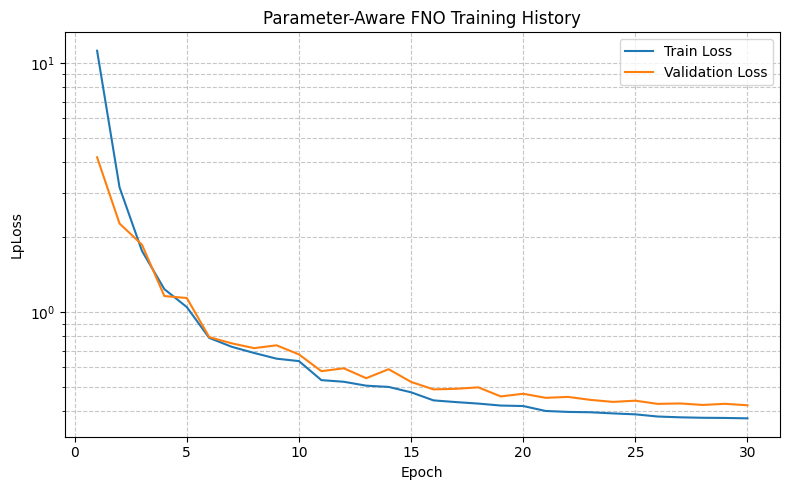

In [9]:
import torch.optim as optim
# ==============================================================================
# Step 3: Data Loading and Preprocessing (Parameter Aware Dataset)
# ==============================================================================
print("\n--- Part 2: Data Preparation for FNO ---")

class RTMParamDataset(Dataset):
    """
    Dataset class for loading RTM simulation data (.npz files)
    and creating parameter-aware input/output pairs for FNO.
    Handles Z-score normalization.
    """
    def __init__(self, file_paths, param_keys, step=1):
        super().__init__()
        self.file_paths = file_paths
        self.param_keys = param_keys
        self.n_params = len(param_keys)
        self.n_state_vars = 2 # P, D
        self.step = step # Time step difference between input/output
        self.data_pairs = []
        self.norm_stats = None # Will be set externally
        self._load_and_create_pairs()

    def _load_and_create_pairs(self):
        print(f"Loading and creating pairs from {len(self.file_paths)} simulation files...")
        for file_path in tqdm(self.file_paths, desc="Loading Files"):
            try:
                data = np.load(file_path)
                # Ensure keys exist
                required_keys = ['P_snaps', 'D_snaps', 'params', 'times']
                if not all(key in data for key in required_keys):
                    print(f"Warning: Skipping {file_path}, missing required keys.")
                    continue

                P_snaps = data['P_snaps'].astype(np.float32) # (Time, Ny, Nx)
                D_snaps = data['D_snaps'].astype(np.float32)
                params_run = data['params'].astype(np.float32) # (N_PARAMS,)
                n_time, Ny, Nx = P_snaps.shape

                if n_time < self.step + 1: # Need at least one pair
                    print(f"Warning: Skipping {file_path}, not enough time steps ({n_time}).")
                    continue
                if len(params_run) != self.n_params:
                     print(f"Warning: Skipping {file_path}, parameter count mismatch (expected {self.n_params}, got {len(params_run)}).")
                     continue

                # Create parameter fields (broadcast parameters to spatial dimensions)
                param_fields = np.zeros((self.n_params, Ny, Nx), dtype=np.float32)
                for i in range(self.n_params):
                    param_fields[i, :, :] = params_run[i]

                # Create input (t) -> output (t+step) pairs
                for t in range(n_time - self.step):
                    in_p = P_snaps[t]
                    in_d = D_snaps[t]
                    out_p = P_snaps[t + self.step]
                    out_d = D_snaps[t + self.step]

                    # Stack input: P, D, param1_field, ... (Channels First)
                    input_state = np.concatenate(
                        (np.stack((in_p, in_d), axis=0), param_fields),
                        axis=0
                    ) # Shape (2 + N_PARAMS, Ny, Nx)

                    # Stack output: P, D (Channels First)
                    output_state = np.stack((out_p, out_d), axis=0) # Shape (2, Ny, Nx)

                    self.data_pairs.append({'input': input_state, 'output': output_state})

            except Exception as e:
                print(f"Warning: Failed to load or process {file_path}: {e}")
                continue # Skip this file

        if not self.data_pairs:
            raise RuntimeError("No data pairs were successfully created!")
        print(f"Created {len(self.data_pairs)} input/output pairs.")

    def set_normalization(self, norm_stats):
        """Sets the normalization statistics calculated from the training set."""
        self.norm_stats = norm_stats
        if norm_stats:
            print(f"Normalization stats set for dataset.") # Don't print full stats here
        else:
            print("Normalization disabled for dataset.")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        pair = self.data_pairs[idx]
        input_state = pair['input'].copy()
        output_state = pair['output'].copy()

        # Apply normalization if stats are available
        if self.norm_stats:
            # State vars P, D (Indices 0, 1)
            input_state[0] = (input_state[0] - self.norm_stats['P_mean']) / self.norm_stats['P_std']
            input_state[1] = (input_state[1] - self.norm_stats['D_mean']) / self.norm_stats['D_std']
            output_state[0] = (output_state[0] - self.norm_stats['P_mean']) / self.norm_stats['P_std']
            output_state[1] = (output_state[1] - self.norm_stats['D_mean']) / self.norm_stats['D_std']

            # Parameters (Indices 2 onwards)
            for i in range(self.n_params):
                input_state[2 + i] = (input_state[2 + i] - self.norm_stats['params_mean'][i]) / self.norm_stats['params_std'][i]

        return torch.from_numpy(input_state), torch.from_numpy(output_state)

# --- Function to calculate normalization stats (Z-score) ---
def calculate_normalization_stats(dataset):
    """Calculates mean/std for state variables and parameters from training dataset."""
    print("Calculating normalization statistics from training data...")
    num_samples_for_stats = min(len(dataset), 5000) # Use a subset for efficiency
    if num_samples_for_stats == 0:
         raise ValueError("Dataset for normalization calculation is empty!")

    subset_indices = np.random.choice(len(dataset), num_samples_for_stats, replace=False)

    # Use lists to accumulate before converting to tensor/numpy array
    p_values = []
    d_values = []
    param_values_list = [[] for _ in range(dataset.n_params)]

    # Iterate through subset to collect raw data before normalization
    # Important: Access raw data, bypass __getitem__'s normalization
    for idx in tqdm(subset_indices, desc="Sampling for Norm Stats"):
        raw_input = dataset.data_pairs[idx]['input']
        p_values.append(raw_input[0].flatten()) # Flatten spatial dims
        d_values.append(raw_input[1].flatten())
        for i in range(dataset.n_params):
            param_values_list[i].append(raw_input[2 + i, 0, 0]) # Params are constant fields

    # Concatenate and calculate stats
    stats = {}
    all_p = np.concatenate(p_values)
    all_d = np.concatenate(d_values)
    stats['P_mean'] = np.mean(all_p).astype(np.float32)
    stats['P_std'] = np.std(all_p).astype(np.float32)
    stats['D_mean'] = np.mean(all_d).astype(np.float32)
    stats['D_std'] = np.std(all_d).astype(np.float32)

    # Parameters
    params_data = np.array(param_values_list).T # Shape (N_subset, N_params)
    stats['params_mean'] = np.mean(params_data, axis=0).astype(np.float32)
    stats['params_std'] = np.std(params_data, axis=0).astype(np.float32)

    # Add small epsilon to std dev
    stats['P_std'] = max(stats['P_std'], 1e-8)
    stats['D_std'] = max(stats['D_std'], 1e-8)
    stats['params_std'][stats['params_std'] < 1e-8] = 1.0 # Set std=1 if param was constant

    print("Normalization Stats Calculated:")
    for key, value in stats.items():
        if isinstance(value, np.ndarray):
             print(f"  {key}: {value}")
        else:
             print(f"  {key}: {value:.4f}")
    return stats

# --- Function to denormalize data ---
def denormalize_data(data_norm, norm_stats):
    """Denormalizes P and D channels of a tensor."""
    if not norm_stats or data_norm is None:
        return data_norm
    data_denorm = data_norm.clone() # Operate on a copy
    # P channel (index 0)
    data_denorm[:, 0] = (data_denorm[:, 0] * norm_stats['P_std']) + norm_stats['P_mean']
    # D channel (index 1)
    data_denorm[:, 1] = (data_denorm[:, 1] * norm_stats['D_std']) + norm_stats['D_mean']
    return data_denorm

# --- Split files and Create Datasets/Loaders ---
TRAIN_TEST_SPLIT = 0.8
BATCH_SIZE = 16 # Adjust based on GPU memory

all_files = sorted(list(DATA_DIR.glob("sim_*.npz")))
if not all_files:
    raise FileNotFoundError(f"No simulation data found in {DATA_DIR}. Generate data first.")

train_files, test_files = train_test_split(all_files, train_size=TRAIN_TEST_SPLIT, random_state=42)
# Further split train into train and validation
train_files, val_files = train_test_split(train_files, train_size=0.9, random_state=42) # 90% of 80% for train

if not train_files: raise ValueError("No files for training set.")
if not val_files: raise ValueError("No files for validation set.")
if not test_files: raise ValueError("No files for test set.")

print(f"Data Split: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)} simulation files.")

# Create datasets (will load data)
train_dataset = RTMParamDataset(train_files, param_keys)
val_dataset = RTMParamDataset(val_files, param_keys)
test_dataset = RTMParamDataset(test_files, param_keys)

# Calculate normalization ONLY from training dataset
norm_statistics = calculate_normalization_stats(train_dataset)

# Apply normalization to all datasets
train_dataset.set_normalization(norm_statistics)
val_dataset.set_normalization(norm_statistics)
test_dataset.set_normalization(norm_statistics)

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


# ==============================================================================
# Step 4: FNO Model Definition and Training (Parameter Aware)
# ==============================================================================
print("\n--- Part 3: FNO Training ---")

# --- Configuration ---
EPOCHS = 30 # Reduced for testing
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
SCHEDULER_STEP = 5
SCHEDULER_GAMMA = 0.5

# FNO Hyperparameters
N_STATE_VARS = 2 # P, D
N_PARAMS = len(param_keys)
N_IN_CHANNELS = N_STATE_VARS + N_PARAMS
N_OUT_CHANNELS = N_STATE_VARS
FNO_N_MODES = (16, 16) # Modes for 2D data (Ny, Nx)
FNO_HIDDEN_CHANNELS = 32
FNO_N_LAYERS = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- FNO Model ---
model = FNO(n_modes=FNO_N_MODES,
            hidden_channels=FNO_HIDDEN_CHANNELS,
            in_channels=N_IN_CHANNELS,
            out_channels=N_OUT_CHANNELS,
            n_layers=FNO_N_LAYERS,
            use_mlp=True,
            mlp_dropout=0.05,
            mlp_expansion=0.5,
            ).to(device)

n_params = count_params(model)
print(f'\nParameter-Aware FNO model initialized with {n_params} parameters.')
print(f'Input channels: {N_IN_CHANNELS}, Output channels: {N_OUT_CHANNELS}')

# --- Loss, Optimizer, Scheduler ---
loss_fn = LpLoss(d=2, p=2) # L2 norm over spatial dimensions
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)

# --- Manual Training Loop ---
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_path = "best_param_aware_fno_model.pth"

print("Starting Parameter-Aware FNO training...")
training_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    model.train()
    train_loss_epoch = 0.0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        pred_batch = model(x_batch)
        loss = loss_fn(pred_batch, y_batch)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * x_batch.size(0) # Accumulate loss weighted by batch size

    train_loss_epoch /= len(train_loader.dataset) # Average loss over dataset
    train_losses.append(train_loss_epoch)

    # Validation
    model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred_batch = model(x_batch)
            loss = loss_fn(pred_batch, y_batch)
            val_loss_epoch += loss.item() * x_batch.size(0)

    val_loss_epoch /= len(val_loader.dataset)
    val_losses.append(val_loss_epoch)

    scheduler.step()

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss_epoch:.4e}, Val Loss: {val_loss_epoch:.4e}, LR: {optimizer.param_groups[0]['lr']:.2e}, Time: {epoch_time:.2f}s")

    # Save best model
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"   -> Saved new best model (Val Loss: {best_val_loss:.4e})")


training_time = time.time() - training_start_time
print(f"\nFNO Training finished in {training_time:.2f} seconds.")

# --- Plot training history ---
plt.figure(figsize=(8, 5))
plt.semilogy(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.semilogy(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('LpLoss')
plt.title('Parameter-Aware FNO Training History')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




--- Part 4: FNO Evaluation ---
Loading best model from best_param_aware_fno_model.pth


<ipython-input-10-56ae5ea3cbd8>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Testing (Single Step):   0%|          | 0/57 [00:00<?, ?it/s]

Final Test Loss (single step, LpLoss): 3.7240e-01
Starting parameter-aware rollout for 10 steps using params: [0.5505713  0.03950674 0.415851   0.61732286 1.7777399 ]
Rollout finished in 0.06 seconds.


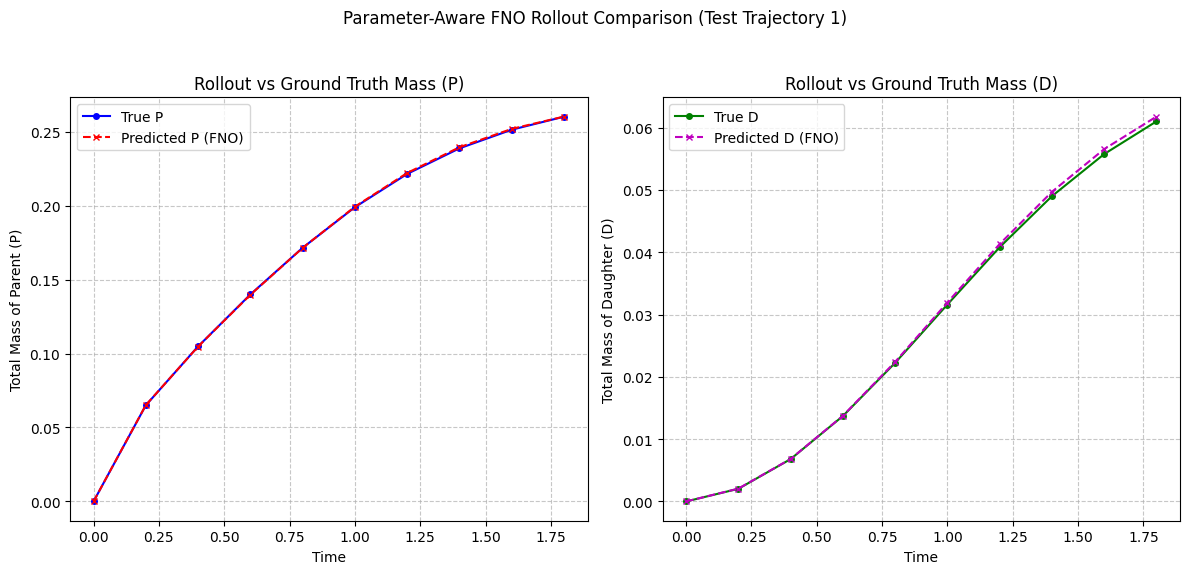

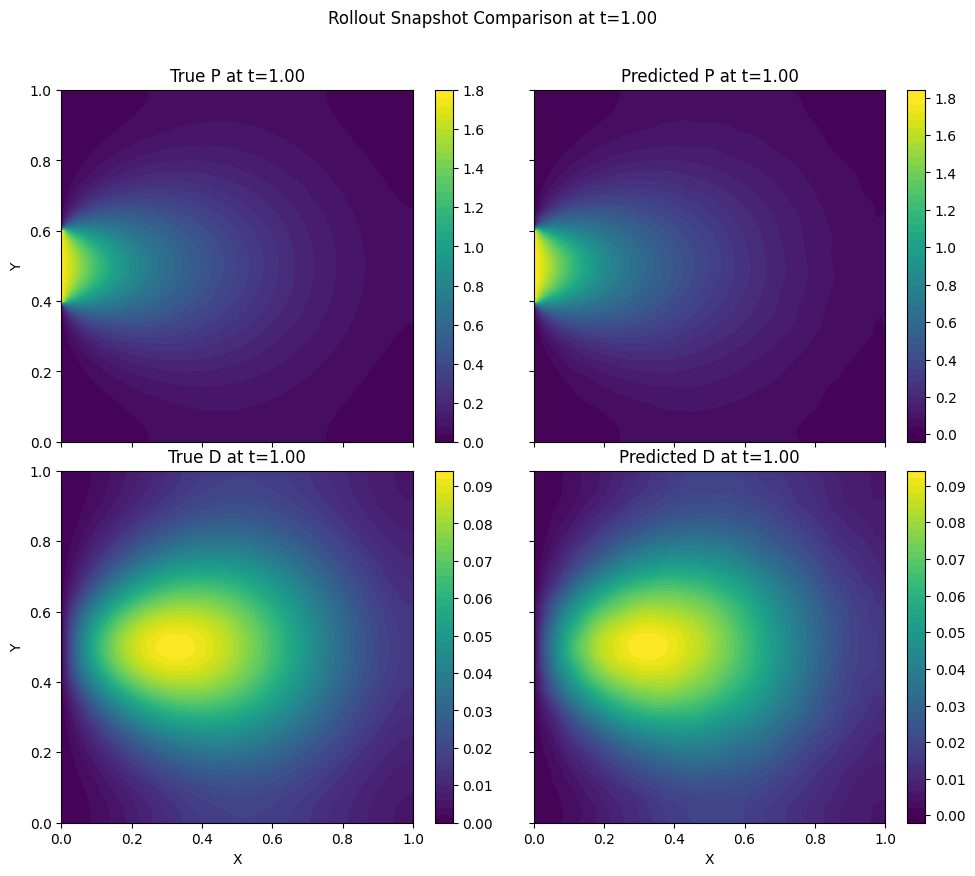


--- FNO Parameter-Aware Run Complete ---


In [10]:
# ==============================================================================
# Step 5: FNO Evaluation (Parameter Aware Rollout)
# ==============================================================================
print("\n--- Part 4: FNO Evaluation ---")

# --- Define Grid Spacing Needed for Evaluation --- ADD THIS ---
# Ensure these match the grid used for simulation/data generation
L_eval = 1.0 # Use the L value used for simulation data
Nx_eval = 81 # Use the Nx value used for simulation data
Ny_eval = 81 # Use the Ny value used for simulation data
dx_eval = L_eval / (Nx_eval - 1)
dy_eval = L_eval / (Ny_eval - 1)

# Load the best model
#best_model_path = '/input/simulation-data/kaggle/working/best_param_aware_fno_model.pth'
if os.path.exists(best_model_path):
     print(f"Loading best model from {best_model_path}")
     model.load_state_dict(torch.load(best_model_path))
     model.eval()
else:
     print("Warning: Best model file not found. Evaluating with last state.")
     model.eval() # Still set to eval mode

# --- Evaluate on Test Set (Single Step Prediction) ---
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing (Single Step)"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred_batch = model(x_batch)
        loss = loss_fn(pred_batch, y_batch)
        test_loss += loss.item() * x_batch.size(0)
test_loss /= len(test_loader.dataset)
print(f"Final Test Loss (single step, LpLoss): {test_loss:.4e}")

# --- Parameter-Aware Autoregressive Rollout ---
# Select a trajectory from the test set
try:
    # Load the first test file to get a full sequence
    test_file_path = test_dataset.file_paths[0]
    test_data_full = np.load(test_file_path)
    P_true_seq = torch.from_numpy(test_data_full['P_snaps'].astype(np.float32)).to(device)
    D_true_seq = torch.from_numpy(test_data_full['D_snaps'].astype(np.float32)).to(device)
    params_true = torch.from_numpy(test_data_full['params'].astype(np.float32)).to(device)
    times_true = test_data_full['times']
    num_rollout_steps = P_true_seq.shape[0]
    Ny_roll, Nx_roll = P_true_seq.shape[1], P_true_seq.shape[2]

    print(f"Starting parameter-aware rollout for {num_rollout_steps} steps using params: {params_true.cpu().numpy()}")

    # Prepare initial state (normalized)
    initial_p_norm = (P_true_seq[0] - norm_statistics['P_mean']) / norm_statistics['P_std']
    initial_d_norm = (D_true_seq[0] - norm_statistics['D_mean']) / norm_statistics['D_std']
    param_fields_norm = torch.zeros(N_PARAMS, Ny_roll, Nx_roll, dtype=torch.float32, device=device)
    for i in range(N_PARAMS):
         param_fields_norm[i, :, :] = (params_true[i] - norm_statistics['params_mean'][i]) / norm_statistics['params_std'][i]

    current_state_norm = torch.cat((initial_p_norm.unsqueeze(0), initial_d_norm.unsqueeze(0), param_fields_norm), dim=0).unsqueeze(0) # Add Batch dim: (1, C, Ny, Nx)

    predicted_rollout_norm_list = [current_state_norm[:, :N_STATE_VARS, :, :].cpu()] # Store only P, D part

    rollout_start_time = time.time()
    with torch.no_grad():
        for i in range(num_rollout_steps - 1):
            next_state_pred_norm = model(current_state_norm) # Predict P, D (normalized)
            predicted_rollout_norm_list.append(next_state_pred_norm.cpu())

            # Prepare input for next step: use predicted P, D + original parameter fields
            current_state_norm = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1) # (1, 2+N_PARAMS, Ny, Nx)

    rollout_time = time.time() - rollout_start_time
    print(f"Rollout finished in {rollout_time:.2f} seconds.")

    # Concatenate predictions and denormalize
    predicted_rollout_norm_tensor = torch.cat(predicted_rollout_norm_list, dim=0) # (T, 2, Ny, Nx)
    predicted_rollout_tensor = denormalize_data(predicted_rollout_norm_tensor, norm_statistics)

    # Ground truth sequence (P, D)
    true_rollout_tensor = torch.stack((P_true_seq, D_true_seq), dim=1) # (T, 2, Ny, Nx)

    # --- Compare Rollout vs True ---
    # Example: Compare total mass evolution
    def calculate_total_mass(conc_tensor, dx, dy):
        # Input shape: (T, C, Ny, Nx) or (C, Ny, Nx)
        if conc_tensor.dim() == 3:
            conc_tensor = conc_tensor.unsqueeze(0)
        # Sum concentration over spatial dims for each channel/time
        total_mass = torch.sum(conc_tensor, dim=(2, 3)) * dx * dy # Approx mass = avg_conc * area
        return total_mass.cpu().numpy() # Move to CPU for plotting

    true_mass_P = calculate_total_mass(true_rollout_tensor[:, 0:1, :, :], dx_eval, dy_eval) # Mass of P
    true_mass_D = calculate_total_mass(true_rollout_tensor[:, 1:2, :, :], dx_eval, dy_eval) # Mass of D
    pred_mass_P = calculate_total_mass(predicted_rollout_tensor[:, 0:1, :, :], dx_eval, dy_eval)
    pred_mass_D = calculate_total_mass(predicted_rollout_tensor[:, 1:2, :, :], dx_eval, dy_eval)

    # Also update the time axis calculation to use T_FINAL_SIM and num_rollout_steps
    rollout_times = np.linspace(0, T_FINAL_SIM * (num_rollout_steps-1)/(N_SNAPSHOTS_SIM-1) , num_rollout_steps) # Approximate time axis

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(times_true, true_mass_P, 'bo-', label='True P', markersize=4)
    plt.plot(times_true, pred_mass_P, 'rx--', label='Predicted P (FNO)', markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Total Mass of Parent (P)')
    plt.title('Rollout vs Ground Truth Mass (P)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(times_true, true_mass_D, 'go-', label='True D', markersize=4)
    plt.plot(times_true, pred_mass_D, 'mx--', label='Predicted D (FNO)', markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Total Mass of Daughter (D)')
    plt.title('Rollout vs Ground Truth Mass (D)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle('Parameter-Aware FNO Rollout Comparison (Test Trajectory 1)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Example: Visualize snapshot comparison
    plot_step = num_rollout_steps // 2
    fig, axes = plt.subplots(2, 2, figsize=(10, 9), sharex=True, sharey=True)

    vmin_p_plot = 0
    vmax_p_plot = torch.max(true_rollout_tensor[plot_step, 0]).item()
    norm_p_plot = plt.Normalize(vmin=vmin_p_plot, vmax=max(vmax_p_plot, 1e-6))

    vmin_d_plot = 0
    vmax_d_plot = torch.max(true_rollout_tensor[plot_step, 1]).item()
    norm_d_plot = plt.Normalize(vmin=vmin_d_plot, vmax=max(vmax_d_plot, 1e-6))

    L_sim = 1.0 # The value used during data generation
    Nx_sim = 81 # The value used during data generation
    Ny_sim = 81 # The value used during data generation

    x_cpu = np.linspace(0, L_sim, Nx_sim) # Use sim grid params
    y_cpu = np.linspace(0, L_sim, Ny_sim)
    X_cpu, Y_cpu = np.meshgrid(x_cpu, y_cpu)

    # True P
    im0 = axes[0,0].contourf(X_cpu, Y_cpu, true_rollout_tensor[plot_step, 0].cpu(), levels=50, cmap='viridis', norm=norm_p_plot)
    axes[0,0].set_title(f'True P at t={times_true[plot_step]:.2f}')
    axes[0,0].set_ylabel("Y")
    fig.colorbar(im0, ax=axes[0,0])
    # Predicted P
    im1 = axes[0,1].contourf(X_cpu, Y_cpu, predicted_rollout_tensor[plot_step, 0].cpu(), levels=50, cmap='viridis', norm=norm_p_plot)
    axes[0,1].set_title(f'Predicted P at t={times_true[plot_step]:.2f}')
    fig.colorbar(im1, ax=axes[0,1])
    # True D
    im2 = axes[1,0].contourf(X_cpu, Y_cpu, true_rollout_tensor[plot_step, 1].cpu(), levels=50, cmap='viridis', norm=norm_d_plot)
    axes[1,0].set_title(f'True D at t={times_true[plot_step]:.2f}')
    axes[1,0].set_xlabel("X"); axes[1,0].set_ylabel("Y")
    fig.colorbar(im2, ax=axes[1,0])
    # Predicted D
    im3 = axes[1,1].contourf(X_cpu, Y_cpu, predicted_rollout_tensor[plot_step, 1].cpu(), levels=50, cmap='viridis', norm=norm_d_plot)
    axes[1,1].set_title(f'Predicted D at t={times_true[plot_step]:.2f}')
    axes[1,1].set_xlabel("X")
    fig.colorbar(im3, ax=axes[1,1])

    for ax in axes.flat: ax.set_aspect('equal', adjustable='box')
    plt.suptitle(f"Rollout Snapshot Comparison at t={times_true[plot_step]:.2f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except IndexError:
     print("Could not perform rollout evaluation - likely no test files loaded or index issue.")
except Exception as e:
    print(f"\nError during final evaluation or plotting: {e}")
    # import traceback; traceback.print_exc()

print("\n--- FNO Parameter-Aware Run Complete ---")

In [3]:
import os

In [11]:
!pip install neuraloperator
import neuralop
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
# --- neuralop imports (adjust based on library structure) ---
try:
    from neuralop.models import FNO # Standard FNO model import
except ImportError:
    print("ERROR: Failed to import FNO from neuralop.models. Please check neuralop installation.")
    raise
try:
    from neuralop.training.trainer import Trainer # Trainer class
except ImportError:
    print("ERROR: Failed to import Trainer from neuralop.training.trainer. Please check neuralop installation.")
    raise
try:
    from neuralop.training.callbacks import CheckpointCallback # Callbacks
    USE_CHECKPOINTING = True
except ImportError:
    print("Warning: Could not import CheckpointCallback. Proceeding without checkpointing.")
    CheckpointCallback = None # Define as None if not found
    USE_CHECKPOINTING = False
try:
    from neuralop.losses import LpLoss # Standard loss function
except ImportError:
    print("ERROR: Failed to import LpLoss from neuralop.losses. Please check neuralop installation.")
    raise
# --- Utility to count parameters (Manual PyTorch way) ---
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
try:
    from neuralop.losses import LpLoss # Standard loss function
except ImportError:
    print("ERROR: Failed to import LpLoss from neuralop.losses. Please check neuralop installation.")
    raise
# --- Utility to count parameters (Manual PyTorch way) ---
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


--- Step 6: Testing FNO Interpolation ---
Loading best model from best_param_aware_fno_model.pth

--- Testing Parameter Set 1/4 ---
Parameters: {'vx': 0.55, 'D': 0.025, 'k_P': 0.4, 'k_D': 0.6, 'P_in': 1.2}
Generating ground truth simulation...


<ipython-input-13-e875520de123>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Running FNO rollout...


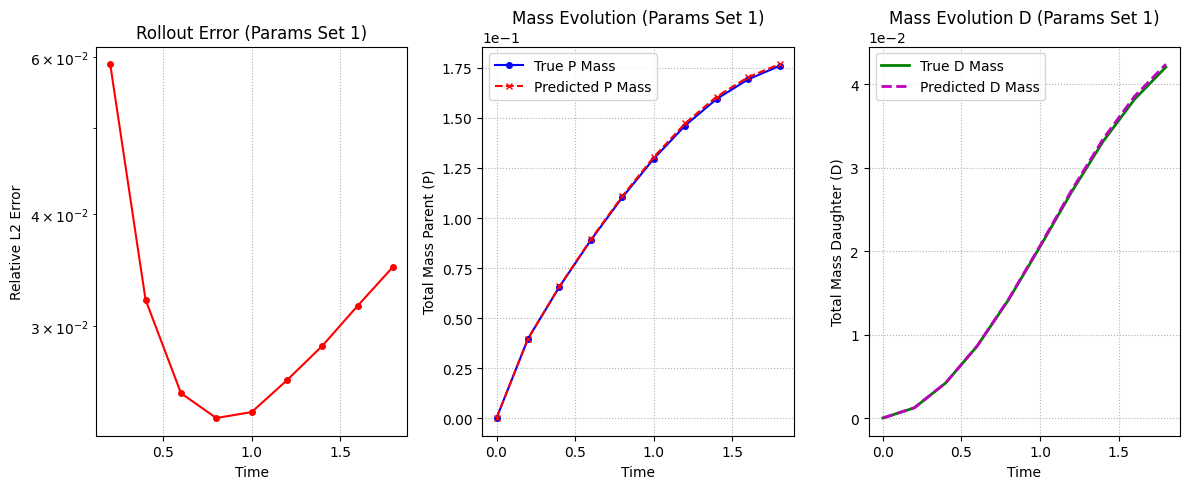


--- Testing Parameter Set 2/4 ---
Parameters: {'vx': 0.2, 'D': 0.015, 'k_P': 0.9, 'k_D': 0.2, 'P_in': 0.8}
Generating ground truth simulation...
Running FNO rollout...


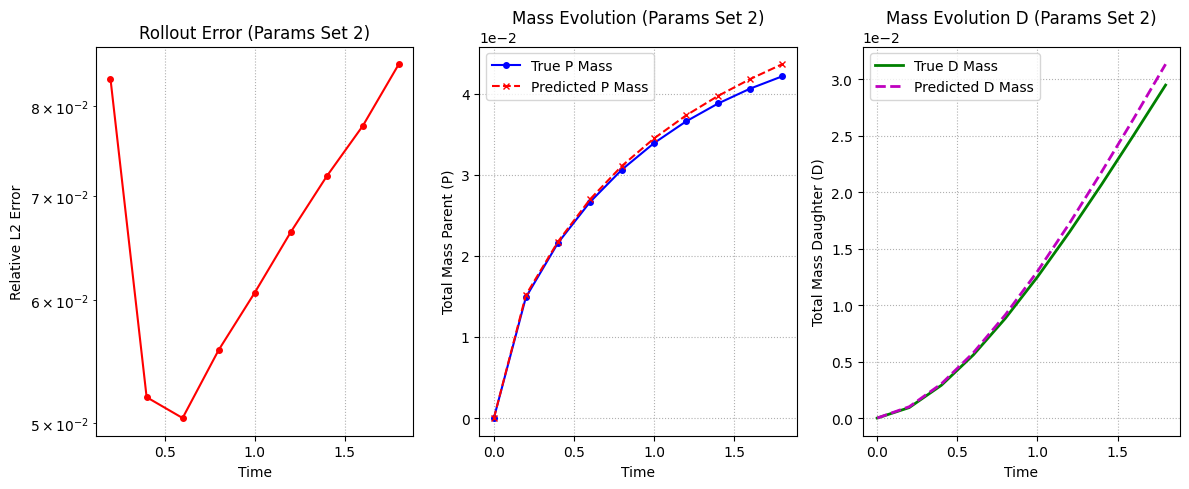


--- Testing Parameter Set 3/4 ---
Parameters: {'vx': 0.1, 'D': 0.03, 'k_P': 0.7, 'k_D': 0.5, 'P_in': 0.4}
Generating ground truth simulation...
Running FNO rollout...


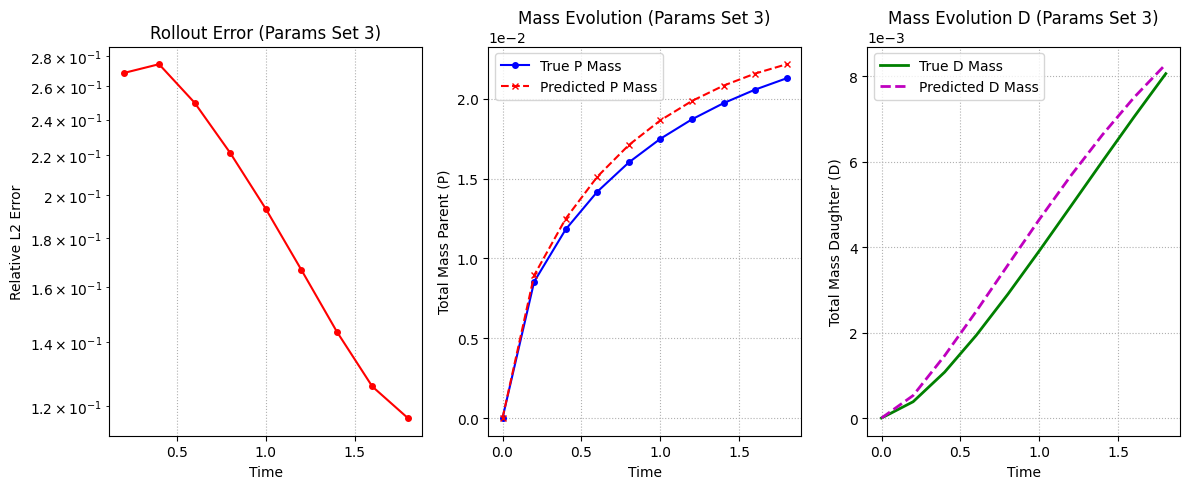


--- Testing Parameter Set 4/4 ---
Parameters: {'vx': 0.7, 'D': 0.01, 'k_P': 1, 'k_D': 1, 'P_in': 0.8}
Generating ground truth simulation...
Running FNO rollout...


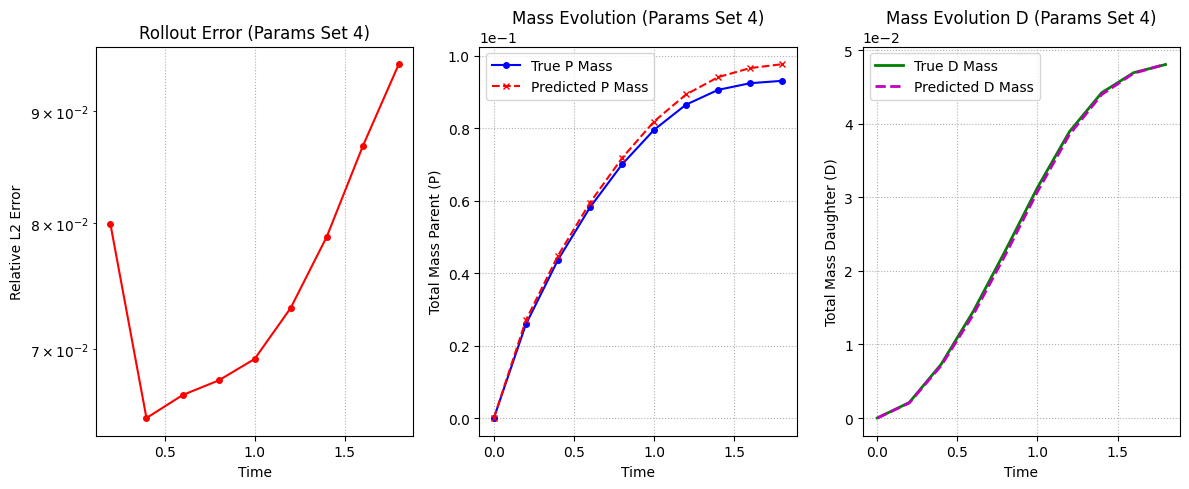


--- FNO Interpolation Test Complete ---


In [13]:
# ==============================================================================
# Step 6: Testing FNO Interpolation Capability
# ==============================================================================
print("\n--- Step 6: Testing FNO Interpolation ---")

# --- Define NEW Parameter Sets for Testing ---
test_param_sets = [
    {'vx': 0.55, 'D': 0.025, 'k_P': 0.4, 'k_D': 0.6, 'P_in': 1.2}, # Example 1
    {'vx': 0.2, 'D': 0.015, 'k_P': 0.9, 'k_D': 0.2, 'P_in': 0.8}, # Example 2
    {'vx': 0.1, 'D': 0.03, 'k_P': 0.7, 'k_D': 0.5, 'P_in': 0.4}, # Example 3
    {'vx': 0.7, 'D': 0.01, 'k_P': 1, 'k_D': 1, 'P_in': 0.8}, # Example 4
    # Add more sets as desired
]

# --- Load the Best Trained FNO Model ---
if os.path.exists(best_model_path):
     print(f"Loading best model from {best_model_path}")
     model.load_state_dict(torch.load(best_model_path))
     model.eval().to(device) # Ensure model is in eval mode and on correct device
else:
     raise FileNotFoundError("Best model checkpoint not found. Cannot run interpolation test.")

# --- Loop through each new parameter set ---
for i, test_params in enumerate(test_param_sets):
    print(f"\n--- Testing Parameter Set {i+1}/{len(test_param_sets)} ---")
    print(f"Parameters: {test_params}")

    # 1. Generate Ground Truth Simulation Data for these params
    print("Generating ground truth simulation...")
    gt_success, gt_P_snaps, gt_D_snaps, gt_times = run_rtm_simulation(
        test_params,
        t_final=T_FINAL_SIM, # Use same duration as training data sims
        num_snapshots=N_SNAPSHOTS_SIM,
        Nx=Nx_sim, Ny=Ny_sim, L=L_sim
    )
    if not gt_success or len(gt_P_snaps) < 2:
        print("Failed to generate ground truth simulation for this parameter set. Skipping.")
        continue

    gt_P_tensor = torch.from_numpy(np.stack(gt_P_snaps)).float().to(device) # (T, Ny, Nx)
    gt_D_tensor = torch.from_numpy(np.stack(gt_D_snaps)).float().to(device)
    gt_full_tensor = torch.stack((gt_P_tensor, gt_D_tensor), dim=1) # (T, 2, Ny, Nx) - Ground Truth

    # 2. Prepare Initial State and Parameter Fields for FNO Rollout
    initial_p_norm = (gt_P_tensor[0] - norm_statistics['P_mean']) / norm_statistics['P_std']
    initial_d_norm = (gt_D_tensor[0] - norm_statistics['D_mean']) / norm_statistics['D_std']

    param_fields_norm = torch.zeros(N_PARAMS, Ny_sim, Nx_sim, dtype=torch.float32, device=device)
    params_true_np = np.array([test_params[key] for key in param_keys], dtype=np.float32)
    params_true = torch.from_numpy(params_true_np).to(device)
    for p_idx in range(N_PARAMS):
         param_fields_norm[p_idx, :, :] = (params_true[p_idx] - norm_statistics['params_mean'][p_idx]) / norm_statistics['params_std'][p_idx]

    current_state_norm = torch.cat(
        (initial_p_norm.unsqueeze(0), initial_d_norm.unsqueeze(0), param_fields_norm),
         dim=0).unsqueeze(0) # Add Batch dim: (1, C_in, Ny, Nx)

    # 3. Run FNO Autoregressive Rollout
    num_rollout_steps = gt_full_tensor.shape[0]
    predicted_rollout_norm_list = [current_state_norm[:, :N_STATE_VARS, :, :].cpu()] # Store P, D part

    print("Running FNO rollout...")
    with torch.no_grad():
        for step in range(num_rollout_steps - 1):
            next_state_pred_norm = model(current_state_norm) # Predict P, D (normalized)
            predicted_rollout_norm_list.append(next_state_pred_norm.cpu())
            # Prepare input for next step
            current_state_norm = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1)

    # 4. Compare FNO Rollout vs. Ground Truth
    predicted_rollout_norm_tensor = torch.cat(predicted_rollout_norm_list, dim=0)
    predicted_rollout_tensor = denormalize_data(predicted_rollout_norm_tensor.to(device), norm_statistics) # Denormalize

    # Calculate relative L2 error over time
    rollout_loss = LpLoss(d=2, p=2) # Use relative loss for comparison
    errors = []
    for t_step in range(num_rollout_steps):
        error_t = rollout_loss(predicted_rollout_tensor[t_step:t_step+1], gt_full_tensor[t_step:t_step+1])
        errors.append(error_t.item())

    # --- Plotting for this parameter set ---
    fig_comp, axes_comp = plt.subplots(1, 3, figsize=(12, 5))
    # Plot error
    axes_comp[0].semilogy(gt_times, errors, 'r-o', markersize=4)
    axes_comp[0].set_xlabel('Time')
    axes_comp[0].set_ylabel('Relative L2 Error')
    axes_comp[0].set_title(f'Rollout Error (Params Set {i+1})')
    axes_comp[0].grid(True, linestyle=':')

    # Plot mass comparison (reuse function, ensure dx_eval, dy_eval defined)
    true_mass_P = calculate_total_mass(gt_full_tensor[:, 0:1, :, :], dx_eval, dy_eval)
    pred_mass_P = calculate_total_mass(predicted_rollout_tensor[:, 0:1, :, :], dx_eval, dy_eval)
    axes_comp[1].plot(gt_times, true_mass_P, 'bo-', label='True P Mass', markersize=4)
    axes_comp[1].plot(gt_times, pred_mass_P, 'rx--', label='Predicted P Mass', markersize=4)
    axes_comp[1].set_xlabel('Time')
    axes_comp[1].set_ylabel('Total Mass Parent (P)')
    axes_comp[1].set_title(f'Mass Evolution (Params Set {i+1})')
    axes_comp[1].legend()
    axes_comp[1].grid(True, linestyle=':')
    axes_comp[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

     # Plot 3: Mass Daughter (D) 
    true_mass_D = calculate_total_mass(gt_full_tensor[:, 1:2, :, :], dx_eval, dy_eval) # Index 1 for Daughter
    pred_mass_D = calculate_total_mass(predicted_rollout_tensor[:, 1:2, :, :], dx_eval, dy_eval) # Index 1 for Daughter
    axes_comp[2].plot(gt_times, true_mass_D, 'g-', label='True D Mass', linewidth=2)
    axes_comp[2].plot(gt_times, pred_mass_D, 'm--', label='Predicted D Mass', linewidth=2)
    axes_comp[2].set_xlabel('Time')
    axes_comp[2].set_ylabel('Total Mass Daughter (D)')
    axes_comp[2].set_title(f'Mass Evolution D (Params Set {i+1})')
    axes_comp[2].legend()
    axes_comp[2].grid(True, linestyle=':')
    axes_comp[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    fig_comp.tight_layout()
    plt.show()

    # Optional: Plot snapshot comparison for this parameter set as before

print("\n--- FNO Interpolation Test Complete ---")

In [3]:
!zip -r working_dir.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/rtm_fno_data/ (stored 0%)
  adding: kaggle/working/rtm_fno_data/sim_0344.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0178.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0270.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0146.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0151.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0398.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0255.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0031.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0196.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0050.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0238.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0183.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0367.npz (deflated 0%)
  adding: kaggle/working/rtm_fno_data/sim_0095.npz (deflated 0%)
 

In [14]:
# ==============================================================================
# Step 0: Import Libraries
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for U-Net padding/interpolation
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# --- neuralop imports (Only LpLoss needed now) ---
try:
    from neuralop.losses import LpLoss
    print("Imported LpLoss from neuralop.losses")
except ImportError:
    print("ERROR: Failed to import LpLoss from neuralop.losses. Using MSE.")
    # Fallback LpLoss using MSE
    class LpLoss(nn.Module):
        def __init__(self, d=2, p=2, reduce_dims=None): # Keep args for signature match
            super().__init__()
            self.mse = nn.MSELoss()
            print("Using MSELoss as fallback for LpLoss.")
        def forward(self, pred, target):
            # Simulate relative L2 behavior approximately with MSE
            loss = self.mse(pred, target)
            target_norm = torch.mean(target**2) # Approx squared L2 norm
            if target_norm > 1e-8:
                loss = loss / target_norm
            return loss


# --- Utility to count parameters (Manual PyTorch way) ---
def count_parameters(model):
    """Counts the number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Standard Libraries ---
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import os
from pathlib import Path
from scipy.stats import qmc
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import random
import gc
import glob


Imported LpLoss from neuralop.losses



--- Part 2: Data Preparation for CNN (U-Net) ---
Data Split: Train=360, Val=40, Test=100 simulation files.
Loading and creating pairs from 360 simulation files...


Loading Files:   0%|          | 0/360 [00:00<?, ?it/s]

Created 3240 input/output pairs.
Loading and creating pairs from 40 simulation files...


Loading Files:   0%|          | 0/40 [00:00<?, ?it/s]

Created 360 input/output pairs.
Loading and creating pairs from 100 simulation files...


Loading Files:   0%|          | 0/100 [00:00<?, ?it/s]

Created 900 input/output pairs.
Calculating normalization statistics from training data...


Sampling for Norm Stats:   0%|          | 0/3240 [00:00<?, ?it/s]

Normalization Stats Calculated:
  P_mean: 0.0951
  P_std: 0.2107
  D_mean: 0.0182
  D_std: 0.0382
  params_mean: [0.54660887 0.0254839  0.5166366  0.5233399  1.237694  ]
  params_std: [0.2654667  0.01430657 0.28074232 0.27413473 0.4371007 ]
Normalization stats set for dataset.
Normalization stats set for dataset.
Normalization stats set for dataset.

--- Defining CNN (U-Net) Model ---

--- Part 3: CNN (U-Net) Training ---
Using device: cuda

U-Net model initialized with 1949474 parameters.
Input channels: 7, Output channels: 2
Starting U-Net training...


Epoch 1/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 1/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/30], CNN Train Loss: 1.0307e+01, CNN Val Loss: 6.0864e+00, LR: 1.00e-03, Time: 5.89s
   -> Saved new best U-Net model (Val Loss: 6.0864e+00)


Epoch 2/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 2/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/30], CNN Train Loss: 7.6125e+00, CNN Val Loss: 4.8673e+00, LR: 1.00e-03, Time: 5.75s
   -> Saved new best U-Net model (Val Loss: 4.8673e+00)


Epoch 3/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 3/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/30], CNN Train Loss: 7.0151e+00, CNN Val Loss: 4.1448e+00, LR: 1.00e-03, Time: 5.70s
   -> Saved new best U-Net model (Val Loss: 4.1448e+00)


Epoch 4/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 4/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/30], CNN Train Loss: 6.8213e+00, CNN Val Loss: 4.6964e+00, LR: 1.00e-03, Time: 5.71s


Epoch 5/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 5/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/30], CNN Train Loss: 6.2843e+00, CNN Val Loss: 4.0581e+00, LR: 5.00e-04, Time: 5.72s
   -> Saved new best U-Net model (Val Loss: 4.0581e+00)


Epoch 6/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 6/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/30], CNN Train Loss: 5.6825e+00, CNN Val Loss: 2.9033e+00, LR: 5.00e-04, Time: 5.72s
   -> Saved new best U-Net model (Val Loss: 2.9033e+00)


Epoch 7/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 7/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/30], CNN Train Loss: 5.1201e+00, CNN Val Loss: 2.4867e+00, LR: 5.00e-04, Time: 5.67s
   -> Saved new best U-Net model (Val Loss: 2.4867e+00)


Epoch 8/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 8/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/30], CNN Train Loss: 5.2881e+00, CNN Val Loss: 3.0481e+00, LR: 5.00e-04, Time: 5.79s


Epoch 9/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 9/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/30], CNN Train Loss: 4.8783e+00, CNN Val Loss: 3.9269e+00, LR: 5.00e-04, Time: 5.74s


Epoch 10/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 10/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/30], CNN Train Loss: 5.0536e+00, CNN Val Loss: 4.0394e+00, LR: 2.50e-04, Time: 5.69s


Epoch 11/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 11/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [11/30], CNN Train Loss: 4.4420e+00, CNN Val Loss: 3.0431e+00, LR: 2.50e-04, Time: 5.72s


Epoch 12/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 12/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [12/30], CNN Train Loss: 4.4591e+00, CNN Val Loss: 3.0458e+00, LR: 2.50e-04, Time: 5.66s


Epoch 13/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 13/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [13/30], CNN Train Loss: 4.3121e+00, CNN Val Loss: 2.5270e+00, LR: 2.50e-04, Time: 5.69s


Epoch 14/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 14/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [14/30], CNN Train Loss: 4.1112e+00, CNN Val Loss: 3.4812e+00, LR: 2.50e-04, Time: 5.72s


Epoch 15/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 15/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [15/30], CNN Train Loss: 4.0150e+00, CNN Val Loss: 3.0747e+00, LR: 1.25e-04, Time: 5.64s


Epoch 16/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 16/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [16/30], CNN Train Loss: 3.8501e+00, CNN Val Loss: 1.9276e+00, LR: 1.25e-04, Time: 5.69s
   -> Saved new best U-Net model (Val Loss: 1.9276e+00)


Epoch 17/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 17/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [17/30], CNN Train Loss: 3.6875e+00, CNN Val Loss: 2.3717e+00, LR: 1.25e-04, Time: 5.73s


Epoch 18/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 18/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [18/30], CNN Train Loss: 3.6274e+00, CNN Val Loss: 3.1859e+00, LR: 1.25e-04, Time: 5.68s


Epoch 19/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 19/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [19/30], CNN Train Loss: 3.5460e+00, CNN Val Loss: 2.3683e+00, LR: 1.25e-04, Time: 5.67s


Epoch 20/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 20/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [20/30], CNN Train Loss: 3.7365e+00, CNN Val Loss: 2.6648e+00, LR: 6.25e-05, Time: 5.70s


Epoch 21/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 21/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [21/30], CNN Train Loss: 3.4199e+00, CNN Val Loss: 3.4984e+00, LR: 6.25e-05, Time: 5.72s


Epoch 22/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 22/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [22/30], CNN Train Loss: 3.3395e+00, CNN Val Loss: 2.1623e+00, LR: 6.25e-05, Time: 5.67s


Epoch 23/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 23/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [23/30], CNN Train Loss: 3.5627e+00, CNN Val Loss: 2.7776e+00, LR: 6.25e-05, Time: 5.66s


Epoch 24/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 24/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [24/30], CNN Train Loss: 3.3915e+00, CNN Val Loss: 2.7325e+00, LR: 6.25e-05, Time: 5.69s


Epoch 25/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 25/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [25/30], CNN Train Loss: 3.2692e+00, CNN Val Loss: 2.6010e+00, LR: 3.13e-05, Time: 5.72s


Epoch 26/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 26/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [26/30], CNN Train Loss: 3.1477e+00, CNN Val Loss: 3.0523e+00, LR: 3.13e-05, Time: 5.69s


Epoch 27/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 27/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [27/30], CNN Train Loss: 3.1523e+00, CNN Val Loss: 2.5616e+00, LR: 3.13e-05, Time: 5.67s


Epoch 28/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 28/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [28/30], CNN Train Loss: 3.1087e+00, CNN Val Loss: 3.1436e+00, LR: 3.13e-05, Time: 5.71s


Epoch 29/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 29/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [29/30], CNN Train Loss: 2.9639e+00, CNN Val Loss: 1.5106e+00, LR: 3.13e-05, Time: 5.71s
   -> Saved new best U-Net model (Val Loss: 1.5106e+00)


Epoch 30/30 [CNN Train]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch 30/30 [CNN Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [30/30], CNN Train Loss: 3.0892e+00, CNN Val Loss: 2.5663e+00, LR: 1.56e-05, Time: 5.64s

U-Net Training finished in 171.37 seconds.


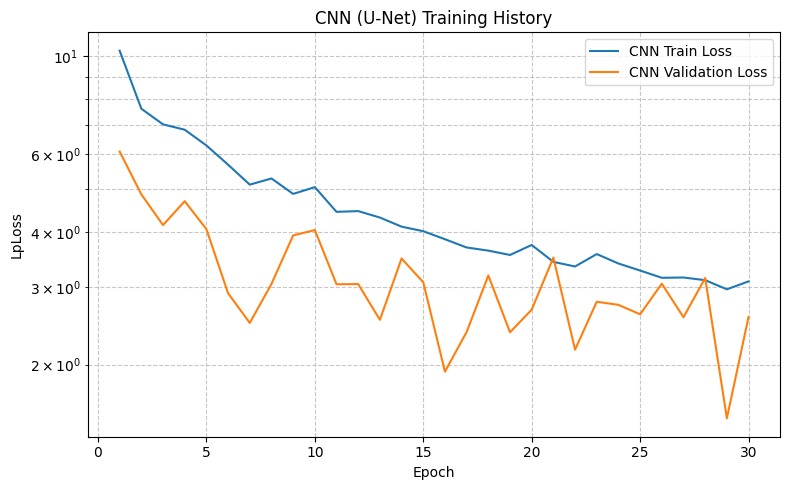


--- Part 4: Comparative Evaluation ---
Loading best FNO model from best_param_aware_fno_model.pth
Best FNO model loaded.
Loading best U-Net model from best_unet_rtm_model.pth
Best U-Net model loaded.


<ipython-input-15-d05280acbdb0>:455: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fno_model.load_state_dict(torch.load(best_fno_model_path))
<ipython-input-15-d05280acbdb0>

Testing FNO (Single Step):   0%|          | 0/57 [00:00<?, ?it/s]

Final FNO Test Loss (single step, LpLoss): 3.7240e-01


Testing U-Net (Single Step):   0%|          | 0/57 [00:00<?, ?it/s]

Final U-Net Test Loss (single step, LpLoss): 1.4309e+00

Loading test trajectory for rollout comparison from: rtm_fno_data/sim_0361.npz
Parameters for this test rollout simulation:
  vx: 0.550571
  D: 0.039507
  k_P: 0.415851
  k_D: 0.617323
  P_in: 1.777740
Running FNO rollout...
FNO rollout complete.
Running U-Net rollout...
U-Net rollout complete.


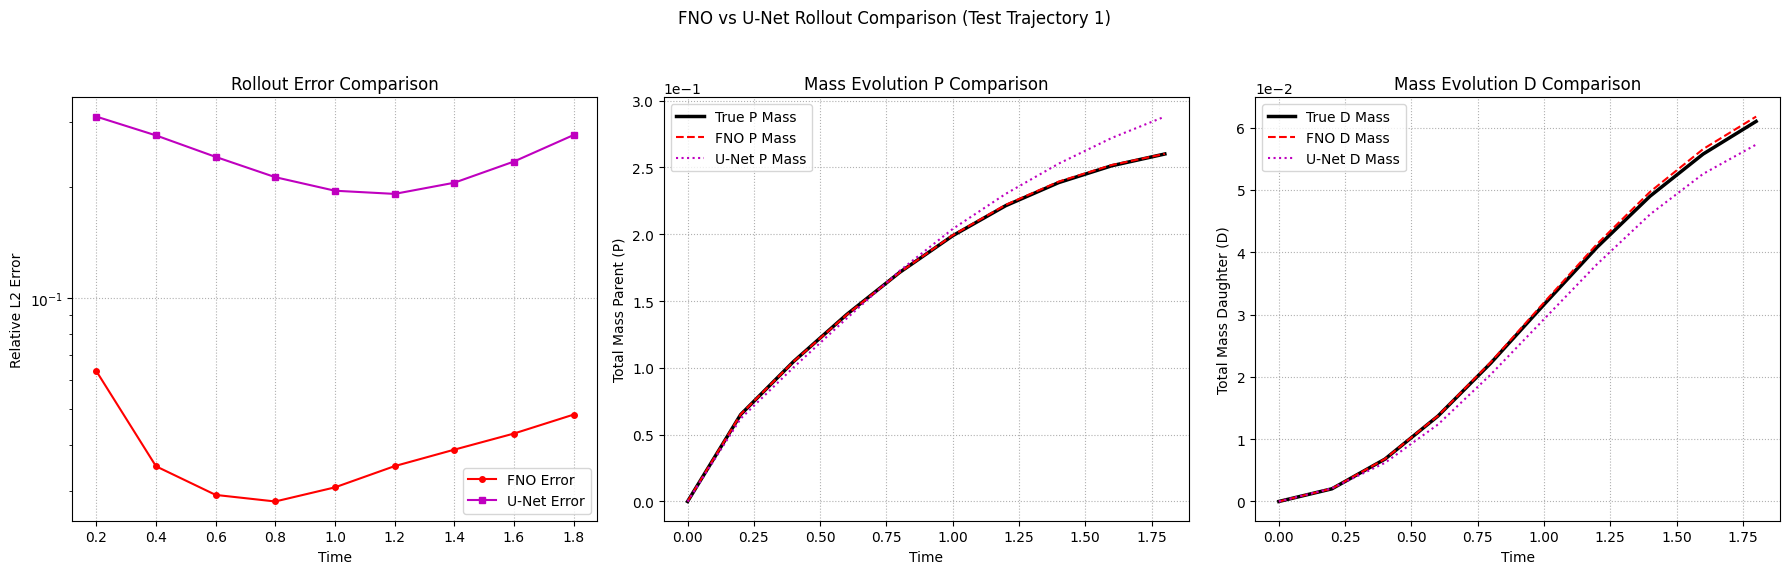


--- Comparative Run Complete ---


In [15]:
# ==============================================================================
# Step 1 & 2: Simulation Function & Data Generation
# ==============================================================================
# KEEP THE EXACT SAME `run_rtm_simulation` function and data generation loop
# Ensure data exists in DATA_DIR = Path("./rtm_fno_data_param")
# Make sure parameters like Nx_sim, Ny_sim, param_keys etc. are defined.
# --- Configuration from Data Generation ---
DATA_DIR = Path("./rtm_fno_data")
L_sim = 1.0
Nx_sim = 81
Ny_sim = 81
param_ranges = { # Must match generation
    'vx': [0.1, 1.0], 'D': [0.001, 0.05], 'k_P': [0.05, 1.0],
    'k_D': [0.05, 1.0], 'P_in': [0.5, 2.0]
}
param_keys = list(param_ranges.keys())
N_PARAMS = len(param_keys)
N_STATE_VARS = 2
T_FINAL_SIM = 2.0 # Match generation t_final
N_SNAPSHOTS_SIM = 11 # Match generation num_snapshots

# ==============================================================================
# Step 3: Data Loading and Preprocessing (Parameter Aware Dataset)
# ==============================================================================
print("\n--- Part 2: Data Preparation for CNN (U-Net) ---")

class RTMParamDataset(Dataset):
    """
    Dataset class for loading RTM simulation data (.npz files)
    and creating parameter-aware input/output pairs for FNO.
    Handles Z-score normalization.
    """
    def __init__(self, file_paths, param_keys, step=1):
        super().__init__()
        self.file_paths = file_paths
        self.param_keys = param_keys
        self.n_params = len(param_keys)
        self.n_state_vars = 2 # P, D
        self.step = step # Time step difference between input/output
        self.data_pairs = []
        self.norm_stats = None # Will be set externally
        self._load_and_create_pairs()

    def _load_and_create_pairs(self):
        print(f"Loading and creating pairs from {len(self.file_paths)} simulation files...")
        for file_path in tqdm(self.file_paths, desc="Loading Files"):
            try:
                data = np.load(file_path)
                # Ensure keys exist
                required_keys = ['P_snaps', 'D_snaps', 'params', 'times']
                if not all(key in data for key in required_keys):
                    print(f"Warning: Skipping {file_path}, missing required keys.")
                    continue

                P_snaps = data['P_snaps'].astype(np.float32) # (Time, Ny, Nx)
                D_snaps = data['D_snaps'].astype(np.float32)
                params_run = data['params'].astype(np.float32) # (N_PARAMS,)
                n_time, Ny, Nx = P_snaps.shape

                if n_time < self.step + 1: # Need at least one pair
                    print(f"Warning: Skipping {file_path}, not enough time steps ({n_time}).")
                    continue
                if len(params_run) != self.n_params:
                     print(f"Warning: Skipping {file_path}, parameter count mismatch (expected {self.n_params}, got {len(params_run)}).")
                     continue

                # Create parameter fields (broadcast parameters to spatial dimensions)
                param_fields = np.zeros((self.n_params, Ny, Nx), dtype=np.float32)
                for i in range(self.n_params):
                    param_fields[i, :, :] = params_run[i]

                # Create input (t) -> output (t+step) pairs
                for t in range(n_time - self.step):
                    in_p = P_snaps[t]
                    in_d = D_snaps[t]
                    out_p = P_snaps[t + self.step]
                    out_d = D_snaps[t + self.step]

                    # Stack input: P, D, param1_field, ... (Channels First)
                    input_state = np.concatenate(
                        (np.stack((in_p, in_d), axis=0), param_fields),
                        axis=0
                    ) # Shape (2 + N_PARAMS, Ny, Nx)

                    # Stack output: P, D (Channels First)
                    output_state = np.stack((out_p, out_d), axis=0) # Shape (2, Ny, Nx)

                    self.data_pairs.append({'input': input_state, 'output': output_state})

            except Exception as e:
                print(f"Warning: Failed to load or process {file_path}: {e}")
                continue # Skip this file

        if not self.data_pairs:
            raise RuntimeError("No data pairs were successfully created!")
        print(f"Created {len(self.data_pairs)} input/output pairs.")

    def set_normalization(self, norm_stats):
        """Sets the normalization statistics calculated from the training set."""
        self.norm_stats = norm_stats
        if norm_stats:
            print(f"Normalization stats set for dataset.") # Don't print full stats here
        else:
            print("Normalization disabled for dataset.")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        pair = self.data_pairs[idx]
        input_state = pair['input'].copy()
        output_state = pair['output'].copy()

        # Apply normalization if stats are available
        if self.norm_stats:
            # State vars P, D (Indices 0, 1)
            input_state[0] = (input_state[0] - self.norm_stats['P_mean']) / self.norm_stats['P_std']
            input_state[1] = (input_state[1] - self.norm_stats['D_mean']) / self.norm_stats['D_std']
            output_state[0] = (output_state[0] - self.norm_stats['P_mean']) / self.norm_stats['P_std']
            output_state[1] = (output_state[1] - self.norm_stats['D_mean']) / self.norm_stats['D_std']

            # Parameters (Indices 2 onwards)
            for i in range(self.n_params):
                input_state[2 + i] = (input_state[2 + i] - self.norm_stats['params_mean'][i]) / self.norm_stats['params_std'][i]

        return torch.from_numpy(input_state), torch.from_numpy(output_state)

# --- Function to calculate normalization stats (Z-score) ---
def calculate_normalization_stats(dataset):
    """Calculates mean/std for state variables and parameters from training dataset."""
    print("Calculating normalization statistics from training data...")
    num_samples_for_stats = min(len(dataset), 5000) # Use a subset for efficiency
    if num_samples_for_stats == 0:
         raise ValueError("Dataset for normalization calculation is empty!")

    subset_indices = np.random.choice(len(dataset), num_samples_for_stats, replace=False)

    # Use lists to accumulate before converting to tensor/numpy array
    p_values = []
    d_values = []
    param_values_list = [[] for _ in range(dataset.n_params)]

    # Iterate through subset to collect raw data before normalization
    # Important: Access raw data, bypass __getitem__'s normalization
    for idx in tqdm(subset_indices, desc="Sampling for Norm Stats"):
        raw_input = dataset.data_pairs[idx]['input']
        p_values.append(raw_input[0].flatten()) # Flatten spatial dims
        d_values.append(raw_input[1].flatten())
        for i in range(dataset.n_params):
            param_values_list[i].append(raw_input[2 + i, 0, 0]) # Params are constant fields

    # Concatenate and calculate stats
    stats = {}
    all_p = np.concatenate(p_values)
    all_d = np.concatenate(d_values)
    stats['P_mean'] = np.mean(all_p).astype(np.float32)
    stats['P_std'] = np.std(all_p).astype(np.float32)
    stats['D_mean'] = np.mean(all_d).astype(np.float32)
    stats['D_std'] = np.std(all_d).astype(np.float32)

    # Parameters
    params_data = np.array(param_values_list).T # Shape (N_subset, N_params)
    stats['params_mean'] = np.mean(params_data, axis=0).astype(np.float32)
    stats['params_std'] = np.std(params_data, axis=0).astype(np.float32)

    # Add small epsilon to std dev
    stats['P_std'] = max(stats['P_std'], 1e-8)
    stats['D_std'] = max(stats['D_std'], 1e-8)
    stats['params_std'][stats['params_std'] < 1e-8] = 1.0 # Set std=1 if param was constant

    print("Normalization Stats Calculated:")
    for key, value in stats.items():
        if isinstance(value, np.ndarray):
             print(f"  {key}: {value}")
        else:
             print(f"  {key}: {value:.4f}")
    return stats

# --- Function to denormalize data ---
def denormalize_data(data_norm, norm_stats):
    """Denormalizes P and D channels of a tensor."""
    if not norm_stats or data_norm is None:
        return data_norm
    data_denorm = data_norm.clone() # Operate on a copy
    # P channel (index 0)
    data_denorm[:, 0] = (data_denorm[:, 0] * norm_stats['P_std']) + norm_stats['P_mean']
    # D channel (index 1)
    data_denorm[:, 1] = (data_denorm[:, 1] * norm_stats['D_std']) + norm_stats['D_mean']
    return data_denorm


# --- Split files and Create Datasets/Loaders (Same as for FNO) ---
TRAIN_TEST_SPLIT = 0.8
BATCH_SIZE = 16 # Keep same batch size for comparison

all_files = sorted(list(DATA_DIR.glob("sim_*.npz")))
if not all_files:
    raise FileNotFoundError(f"No simulation data found in {DATA_DIR}.")

train_files, test_files = train_test_split(all_files, train_size=TRAIN_TEST_SPLIT, random_state=42)
train_files, val_files = train_test_split(train_files, train_size=0.9, random_state=42)

if not train_files: raise ValueError("No files for training set.")
if not val_files: raise ValueError("No files for validation set.")
if not test_files: raise ValueError("No files for test set.")

print(f"Data Split: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)} simulation files.")

train_dataset = RTMParamDataset(train_files, param_keys)
val_dataset = RTMParamDataset(val_files, param_keys)
test_dataset = RTMParamDataset(test_files, param_keys)

norm_statistics = calculate_normalization_stats(train_dataset)

train_dataset.set_normalization(norm_statistics)
val_dataset.set_normalization(norm_statistics)
test_dataset.set_normalization(norm_statistics)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- Denormalize function (needed for evaluation/plotting) ---
def denormalize_data(data_norm, norm_stats):
    # ... (Same definition as in the working FNO code) ...
    if not norm_stats or data_norm is None: return data_norm
    data_denorm = data_norm.clone()
    data_denorm[:, 0] = (data_denorm[:, 0] * norm_stats['P_std']) + norm_stats['P_mean']
    data_denorm[:, 1] = (data_denorm[:, 1] * norm_stats['D_std']) + norm_stats['D_mean']
    return data_denorm


# ==============================================================================
# Step 4: CNN (U-Net) Model Definition
# ==============================================================================
print("\n--- Defining CNN (U-Net) Model ---")

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    # --- No change here ---
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    # --- No change here ---
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels_below, in_channels_skip, out_channels, bilinear=True): # MODIFIED SIGNATURE
        super().__init__()
        self.in_channels_total = in_channels_below + in_channels_skip # Total after concat
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Conv takes the total concatenated channels as input
            self.conv = DoubleConv(self.in_channels_total, out_channels) # Pass total channels to DoubleConv
        else:
            # ConvTranspose reduces channels from below layer BEFORE concat
            self.up = nn.ConvTranspose2d(in_channels_below, in_channels_below // 2, kernel_size=2, stride=2)
             # Conv takes channels from transpose + skip connection
            self.conv = DoubleConv(in_channels_below // 2 + in_channels_skip, out_channels)


    def forward(self, x1, x2):
        # x1 from below (e.g., 256 channels), x2 skip connection (e.g., 128 channels)
        x1 = self.up(x1) # Upsample (and maybe change channels if ConvTranspose)

        # Pad x1 to match x2 size
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1) # Concatenate along channel dimension
        return self.conv(x) # Pass concatenated tensor to conv block

class OutConv(nn.Module):
    # --- No change here ---
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNetRTM(nn.Module):
    def __init__(self, n_channels_in, n_channels_out, bilinear=True):
        super(UNetRTM, self).__init__()
        if n_channels_in <= 0 or n_channels_out <= 0:
             raise ValueError("Number of input/output channels must be positive")
        self.n_channels_in = n_channels_in
        self.n_channels_out = n_channels_out
        self.bilinear = bilinear

        f = 32 # Base number of features

        self.inc = DoubleConv(n_channels_in, f)   # Out: f
        self.down1 = Down(f, f*2)                 # Out: f*2
        self.down2 = Down(f*2, f*4)               # Out: f*4
        self.down3 = Down(f*4, f*8)               # Out: f*8

        # Define Up layers with separate channel inputs
        # Up(channels_below, channels_skip, channels_output)
        self.up2 = Up(f*8, f*4, f*4, bilinear)     # In: f*8 (below), f*4 (skip) -> Out: f*4
        self.up3 = Up(f*4, f*2, f*2, bilinear)     # In: f*4 (below), f*2 (skip) -> Out: f*2
        self.up4 = Up(f*2, f, f, bilinear)         # In: f*2 (below), f (skip)   -> Out: f
        self.outc = OutConv(f, n_channels_out)     # In: f -> Out: n_out

    def forward(self, x):
        x1 = self.inc(x)       # -> f
        x2 = self.down1(x1)    # -> f*2
        x3 = self.down2(x2)    # -> f*4
        x4 = self.down3(x3)    # -> f*8

        x = self.up2(x4, x3)   # Pass f*8 from below (x4), f*4 skip (x3)
        x = self.up3(x, x2)    # Pass f*4 from below (x), f*2 skip (x2)
        x = self.up4(x, x1)    # Pass f*2 from below (x), f skip (x1)
        logits = self.outc(x)
        return logits

# ==============================================================================
# Step 5: CNN (U-Net) Model Training
# ==============================================================================
print("\n--- Part 3: CNN (U-Net) Training ---")

# --- Configuration ---
# Use same config as FNO for fair comparison
EPOCHS = 30
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
SCHEDULER_STEP = 5
SCHEDULER_GAMMA = 0.5
N_STATE_VARS = 2
N_PARAMS = len(param_keys)
N_IN_CHANNELS_CNN = N_STATE_VARS + N_PARAMS
N_OUT_CHANNELS_CNN = N_STATE_VARS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Instantiate U-Net ---
unet_model = UNetRTM(n_channels_in=N_IN_CHANNELS_CNN, n_channels_out=N_OUT_CHANNELS_CNN).to(device)
unet_n_params = count_parameters(unet_model)
print(f'\nU-Net model initialized with {unet_n_params} parameters.')
print(f'Input channels: {N_IN_CHANNELS_CNN}, Output channels: {N_OUT_CHANNELS_CNN}')


# --- Loss, Optimizer, Scheduler ---
loss_fn_cnn = LpLoss(d=2, p=2) # Use same LpLoss instance type
optimizer_cnn = optim.AdamW(unet_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_cnn = optim.lr_scheduler.StepLR(optimizer_cnn, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)

# --- Manual Training Loop for U-Net ---
train_losses_cnn = []
val_losses_cnn = []
best_val_loss_cnn = float('inf')
best_unet_model_path = "best_unet_rtm_model.pth"

print("Starting U-Net training...")
unet_training_start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    unet_model.train()
    train_loss_epoch = 0.0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [CNN Train]", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer_cnn.zero_grad()
        pred_batch = unet_model(x_batch)
        loss = loss_fn_cnn(pred_batch, y_batch)
        loss.backward()
        optimizer_cnn.step()
        train_loss_epoch += loss.item() * x_batch.size(0)

    train_loss_epoch /= len(train_loader.dataset)
    train_losses_cnn.append(train_loss_epoch)

    # Validation
    unet_model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [CNN Val]", leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred_batch = unet_model(x_batch)
            loss = loss_fn_cnn(pred_batch, y_batch)
            val_loss_epoch += loss.item() * x_batch.size(0)

    val_loss_epoch /= len(val_loader.dataset)
    val_losses_cnn.append(val_loss_epoch)

    scheduler_cnn.step()

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{EPOCHS}], CNN Train Loss: {train_loss_epoch:.4e}, CNN Val Loss: {val_loss_epoch:.4e}, LR: {optimizer_cnn.param_groups[0]['lr']:.2e}, Time: {epoch_time:.2f}s")

    # Save best model
    if val_loss_epoch < best_val_loss_cnn:
        best_val_loss_cnn = val_loss_epoch
        torch.save(unet_model.state_dict(), best_unet_model_path)
        print(f"   -> Saved new best U-Net model (Val Loss: {best_val_loss_cnn:.4e})")


unet_training_time = time.time() - unet_training_start_time
print(f"\nU-Net Training finished in {unet_training_time:.2f} seconds.")

# --- Plot U-Net training history ---
plt.figure(figsize=(8, 5))
plt.semilogy(range(1, EPOCHS + 1), train_losses_cnn, label='CNN Train Loss')
plt.semilogy(range(1, EPOCHS + 1), val_losses_cnn, label='CNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('LpLoss')
plt.title('CNN (U-Net) Training History')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# ==============================================================================
# Step 6: Comparative Evaluation (U-Net vs FNO)
# ==============================================================================
print("\n--- Part 4: Comparative Evaluation ---")

# --- Load Best FNO Model (Assuming it was trained separately and path exists) ---
# Replace with your actual best FNO model path if different
best_fno_model_path = "best_param_aware_fno_model.pth"
if os.path.exists(best_fno_model_path):
     print(f"Loading best FNO model from {best_fno_model_path}")
     # Re-instantiate FNO architecture
     fno_model = FNO(n_modes=FNO_N_MODES, hidden_channels=FNO_HIDDEN_CHANNELS,
                     in_channels=N_IN_CHANNELS_CNN, out_channels=N_OUT_CHANNELS_CNN, # Use CNN dims for consistency
                     n_layers=FNO_N_LAYERS, use_mlp=True, mlp_dropout=0.05, mlp_expansion=0.5).to(device)
     fno_model.load_state_dict(torch.load(best_fno_model_path))
     fno_model.eval()
     print("Best FNO model loaded.")
else:
     print(f"Warning: Best FNO model path '{best_fno_model_path}' not found. Cannot compare.")
     fno_model = None # Set to None if not found


# --- Load Best U-Net Model ---
if os.path.exists(best_unet_model_path):
    print(f"Loading best U-Net model from {best_unet_model_path}")
    # U-Net model already instantiated as unet_model
    unet_model.load_state_dict(torch.load(best_unet_model_path))
    unet_model.eval()
    print("Best U-Net model loaded.")
else:
     print("Warning: Best U-Net model path not found.")
     # Keep unet_model as the last state from training if file not found

# --- Evaluate on Test Set (Single Step) ---
test_loss_fno = float('inf')
test_loss_unet = float('inf')
eval_loss_fn = LpLoss(d=2, p=2) # Use same loss for eval

# Evaluate FNO
if fno_model:
    test_loss_fno = 0.0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Testing FNO (Single Step)"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred_batch = fno_model(x_batch)
            loss = eval_loss_fn(pred_batch, y_batch)
            test_loss_fno += loss.item() * x_batch.size(0)
    test_loss_fno /= len(test_loader.dataset)
    print(f"Final FNO Test Loss (single step, LpLoss): {test_loss_fno:.4e}")

# Evaluate U-Net
test_loss_unet = 0.0
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing U-Net (Single Step)"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred_batch = unet_model(x_batch)
        loss = eval_loss_fn(pred_batch, y_batch)
        test_loss_unet += loss.item() * x_batch.size(0)
test_loss_unet /= len(test_loader.dataset)
print(f"Final U-Net Test Loss (single step, LpLoss): {test_loss_unet:.4e}")


# --- Autoregressive Rollout Comparison ---
# Select a trajectory from the test set (same one for both models)
try:
    test_file_path = test_dataset.file_paths[0] # Use first test file
    print(f"\nLoading test trajectory for rollout comparison from: {test_file_path}")
    test_data_full = np.load(test_file_path)
    params_true_np = test_data_full['params'].astype(np.float32)
    P_true_seq = torch.from_numpy(test_data_full['P_snaps'].astype(np.float32)).to(device)
    D_true_seq = torch.from_numpy(test_data_full['D_snaps'].astype(np.float32)).to(device)
    times_true = test_data_full['times']
    num_rollout_steps = P_true_seq.shape[0]
    Ny_roll, Nx_roll = P_true_seq.shape[1], P_true_seq.shape[2]
    gt_full_tensor = torch.stack((P_true_seq, D_true_seq), dim=1).to(device) # (T, 2, Ny, Nx) - Ground Truth

    print("Parameters for this test rollout simulation:")
    for key, val in zip(param_keys, params_true_np): print(f"  {key}: {val:.6f}")

    # Prepare initial state and parameter fields (normalized)
    initial_p_norm = (P_true_seq[0] - norm_statistics['P_mean']) / norm_statistics['P_std']
    initial_d_norm = (D_true_seq[0] - norm_statistics['D_mean']) / norm_statistics['D_std']
    param_fields_norm = torch.zeros(N_PARAMS, Ny_roll, Nx_roll, dtype=torch.float32, device=device)
    params_true = torch.from_numpy(params_true_np).to(device)
    for p_idx in range(N_PARAMS):
         param_fields_norm[p_idx, :, :] = (params_true[p_idx] - norm_statistics['params_mean'][p_idx]) / norm_statistics['params_std'][p_idx]
    initial_state_norm = torch.cat(
        (initial_p_norm.unsqueeze(0), initial_d_norm.unsqueeze(0), param_fields_norm),
         dim=0).unsqueeze(0) # Add Batch dim: (1, C_in, Ny, Nx)

    # --- Run FNO Rollout ---
    predicted_rollout_fno_tensor = None
    if fno_model:
        print("Running FNO rollout...")
        fno_rollout_norm_list = [initial_state_norm[:, :N_STATE_VARS, :, :].cpu()]
        current_state_fno = initial_state_norm.clone()
        with torch.no_grad():
            for step in range(num_rollout_steps - 1):
                next_state_pred_norm = fno_model(current_state_fno)
                fno_rollout_norm_list.append(next_state_pred_norm.cpu())
                current_state_fno = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1)
        predicted_rollout_fno_norm = torch.cat(fno_rollout_norm_list, dim=0)
        predicted_rollout_fno_tensor = denormalize_data(predicted_rollout_fno_norm.to(device), norm_statistics)
        print("FNO rollout complete.")

    # --- Run U-Net Rollout ---
    print("Running U-Net rollout...")
    unet_rollout_norm_list = [initial_state_norm[:, :N_STATE_VARS, :, :].cpu()]
    current_state_unet = initial_state_norm.clone()
    with torch.no_grad():
        for step in range(num_rollout_steps - 1):
            next_state_pred_norm = unet_model(current_state_unet)
            unet_rollout_norm_list.append(next_state_pred_norm.cpu())
            current_state_unet = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1)
    predicted_rollout_unet_norm = torch.cat(unet_rollout_norm_list, dim=0)
    predicted_rollout_unet_tensor = denormalize_data(predicted_rollout_unet_norm.to(device), norm_statistics)
    print("U-Net rollout complete.")

    # --- Compare Rollouts ---
    # Calculate relative L2 error over time
    rollout_loss_fn = LpLoss(d=2, p=2)
    errors_fno = []
    errors_unet = []
    if fno_model is not None:
        for t_step in range(num_rollout_steps):
            error_fno = rollout_loss_fn(predicted_rollout_fno_tensor[t_step:t_step+1], gt_full_tensor[t_step:t_step+1])
            errors_fno.append(error_fno.item())
    for t_step in range(num_rollout_steps):
        error_unet = rollout_loss_fn(predicted_rollout_unet_tensor[t_step:t_step+1], gt_full_tensor[t_step:t_step+1])
        errors_unet.append(error_unet.item())

    # Define dx, dy for mass calculation
    dx_eval = L_sim / (Nx_sim - 1)
    dy_eval = L_sim / (Ny_sim - 1)
    # Mass function (ensure it's defined)
    def calculate_total_mass(conc_tensor, dx, dy):
        if conc_tensor.dim() == 3: conc_tensor = conc_tensor.unsqueeze(0)
        total_mass = torch.sum(conc_tensor, dim=(2, 3)) * dx * dy
        return total_mass.cpu().numpy()

    true_mass_P = calculate_total_mass(gt_full_tensor[:, 0:1, :, :], dx_eval, dy_eval)
    true_mass_D = calculate_total_mass(gt_full_tensor[:, 1:2, :, :], dx_eval, dy_eval)
    pred_mass_P_fno = calculate_total_mass(predicted_rollout_fno_tensor[:, 0:1, :, :], dx_eval, dy_eval) if fno_model else None
    pred_mass_D_fno = calculate_total_mass(predicted_rollout_fno_tensor[:, 1:2, :, :], dx_eval, dy_eval) if fno_model else None
    pred_mass_P_unet = calculate_total_mass(predicted_rollout_unet_tensor[:, 0:1, :, :], dx_eval, dy_eval)
    pred_mass_D_unet = calculate_total_mass(predicted_rollout_unet_tensor[:, 1:2, :, :], dx_eval, dy_eval)

    # --- Plotting Comparisons ---
    plt.figure(figsize=(18, 6))

    # Error Plot
    plt.subplot(1, 3, 1)
    if fno_model: plt.semilogy(times_true, errors_fno, 'r-o', label='FNO Error', markersize=4)
    plt.semilogy(times_true, errors_unet, 'm-s', label='U-Net Error', markersize=4)
    plt.xlabel('Time')
    plt.ylabel('Relative L2 Error')
    plt.title('Rollout Error Comparison')
    plt.legend()
    plt.grid(True, linestyle=':')

    # Mass P Plot
    plt.subplot(1, 3, 2)
    plt.plot(times_true, true_mass_P, 'k-', label='True P Mass', linewidth=2.5)
    if fno_model: plt.plot(times_true, pred_mass_P_fno, 'r--', label='FNO P Mass', linewidth=1.5)
    plt.plot(times_true, pred_mass_P_unet, 'm:', label='U-Net P Mass', linewidth=1.5)
    plt.xlabel('Time')
    plt.ylabel('Total Mass Parent (P)')
    plt.title('Mass Evolution P Comparison')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # Mass D Plot
    plt.subplot(1, 3, 3)
    plt.plot(times_true, true_mass_D, 'k-', label='True D Mass', linewidth=2.5)
    if fno_model: plt.plot(times_true, pred_mass_D_fno, 'r--', label='FNO D Mass', linewidth=1.5)
    plt.plot(times_true, pred_mass_D_unet, 'm:', label='U-Net D Mass', linewidth=1.5)
    plt.xlabel('Time')
    plt.ylabel('Total Mass Daughter (D)')
    plt.title('Mass Evolution D Comparison')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.suptitle('FNO vs U-Net Rollout Comparison (Test Trajectory 1)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Optional: Add side-by-side snapshot visualizations comparing FNO, U-Net, and Ground Truth


except FileNotFoundError as e:
     print(f"Error loading test file for rollout: {e}")
except IndexError as e:
     print(f"Index error during rollout evaluation: {e}")
except Exception as e:
    print(f"\nError during final comparison evaluation or plotting: {e}")
    import traceback; traceback.print_exc() # Print full traceback for debugging

print("\n--- Comparative Run Complete ---")

In [ ]:
# ==============================================================================
# Step 6: Comparative Evaluation (U-Net vs FNO on Multiple Test Cases)
# ==============================================================================
print("\n--- Part 4: Comparative Evaluation on Multiple Test Cases ---")

# --- Load Best FNO Model ---
best_fno_model_path = "best_param_aware_fno_model.pth"
fno_model = None # Initialize as None
if os.path.exists(best_fno_model_path):
    print(f"Loading best FNO model from {best_fno_model_path}")
    try:
        # Define FNO architecture before loading state_dict
        fno_model = FNO(n_modes=FNO_N_MODES, hidden_channels=FNO_HIDDEN_CHANNELS,
                        in_channels=N_IN_CHANNELS_CNN, out_channels=N_OUT_CHANNELS_CNN,
                        n_layers=FNO_N_LAYERS, use_mlp=True, mlp_dropout=0.05, mlp_expansion=0.5)
        fno_model.load_state_dict(torch.load(best_fno_model_path, map_location=device))
        fno_model.eval().to(device)
        print("Best FNO model loaded.")
    except Exception as e:
        print(f"Error loading FNO model: {e}. FNO comparisons will be skipped.")
        fno_model = None
else:
    print(f"Warning: Best FNO model path '{best_fno_model_path}' not found. FNO comparisons will be skipped.")


# --- Load Best U-Net Model ---
best_unet_model_path = "best_unet_rtm_model.pth"
unet_model = None # Initialize as None
if os.path.exists(best_unet_model_path):
    print(f"Loading best U-Net model from {best_unet_model_path}")
    try:
         # Define U-Net architecture before loading state_dict
        unet_model = UNetRTM(n_channels_in=N_IN_CHANNELS_CNN, n_channels_out=N_OUT_CHANNELS_CNN, bilinear=True)
        unet_model.load_state_dict(torch.load(best_unet_model_path, map_location=device))
        unet_model.eval().to(device)
        print("Best U-Net model loaded.")
    except Exception as e:
        print(f"Error loading U-Net model: {e}. U-Net comparisons will be skipped.")
        unet_model = None
else:
    print(f"Warning: Best U-Net model path '{best_unet_model_path}' not found. U-Net comparisons will be skipped.")


# --- Evaluate on Test Set (Single Step) ---
# ... (Keep the single-step evaluation loop as before to get average test loss) ...
# ... (Print Final FNO Test Loss and Final U-Net Test Loss) ...


# --- Autoregressive Rollout Comparison on Multiple Test Trajectories ---
N_TEST_TRAJECTORIES = 5 # Number of different test cases to evaluate rollout on
if len(test_files) < N_TEST_TRAJECTORIES:
    print(f"Warning: Only {len(test_files)} test files available, reducing N_TEST_TRAJECTORIES.")
    N_TEST_TRAJECTORIES = len(test_files)

# Ensure dx_eval, dy_eval are defined
dx_eval = L_sim / (Nx_sim - 1)
dy_eval = L_sim / (Ny_sim - 1)
# Ensure mass calculation function is defined
def calculate_total_mass(conc_tensor, dx, dy): # ... (definition as before) ...
    pass

print(f"\n--- Starting Rollout Comparison for {N_TEST_TRAJECTORIES} Test Trajectories ---")

# Store results for averaging later if needed
all_fno_rollout_errors = []
all_unet_rollout_errors = []

# Loop through the first N_TEST_TRAJECTORIES files in the test set
for i in range(N_TEST_TRAJECTORIES):
    test_file_path = test_files[i]
    print(f"\n===== Evaluating Test Trajectory {i+1}/{N_TEST_TRAJECTORIES} ({os.path.basename(test_file_path)}) =====")

    try:
        # Load Ground Truth Data
        test_data_full = np.load(test_file_path)
        params_true_np = test_data_full['params'].astype(np.float32)
        P_true_seq = torch.from_numpy(test_data_full['P_snaps'].astype(np.float32)).to(device)
        D_true_seq = torch.from_numpy(test_data_full['D_snaps'].astype(np.float32)).to(device)
        times_true = test_data_full['times']
        num_rollout_steps = P_true_seq.shape[0]
        Ny_roll, Nx_roll = P_true_seq.shape[1], P_true_seq.shape[2]
        gt_full_tensor = torch.stack((P_true_seq, D_true_seq), dim=1).to(device)

        print("Parameters for this test rollout simulation:")
        for key, val in zip(param_keys, params_true_np): print(f"  {key}: {val:.6f}")

        # Prepare initial state and parameter fields (normalized)
        initial_p_norm = (P_true_seq[0] - norm_statistics['P_mean']) / norm_statistics['P_std']
        initial_d_norm = (D_true_seq[0] - norm_statistics['D_mean']) / norm_statistics['D_std']
        param_fields_norm = torch.zeros(N_PARAMS, Ny_roll, Nx_roll, dtype=torch.float32, device=device)
        params_true = torch.from_numpy(params_true_np).to(device)
        for p_idx in range(N_PARAMS):
             param_fields_norm[p_idx, :, :] = (params_true[p_idx] - norm_statistics['params_mean'][p_idx]) / norm_statistics['params_std'][p_idx]
        initial_state_norm = torch.cat(
            (initial_p_norm.unsqueeze(0), initial_d_norm.unsqueeze(0), param_fields_norm),
             dim=0).unsqueeze(0)

        # --- Run FNO Rollout (if model loaded) ---
        predicted_rollout_fno_tensor = None
        errors_fno = []
        if fno_model:
            print("Running FNO rollout...")
            fno_rollout_norm_list = [initial_state_norm[:, :N_STATE_VARS, :, :]]
            current_state_fno = initial_state_norm.clone()
            rollout_start_time = time.time()
            with torch.no_grad():
                for step in range(num_rollout_steps - 1):
                    next_state_pred_norm = fno_model(current_state_fno)
                    fno_rollout_norm_list.append(next_state_pred_norm)
                    current_state_fno = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1)
            rollout_end_time = time.time()
            print(f"FNO rollout complete in {rollout_end_time - rollout_start_time:.3f}s.")
            predicted_rollout_fno_norm = torch.cat(fno_rollout_norm_list, dim=0)
            predicted_rollout_fno_tensor = denormalize_data(predicted_rollout_fno_norm, norm_statistics)

            # Calculate error
            rollout_loss_fn = LpLoss(d=2, p=2) # Use relative loss
            gt_full_tensor_norm = torch.stack(((gt_full_tensor[:,0]-norm_statistics['P_mean'])/norm_statistics['P_std'],
                                               (gt_full_tensor[:,1]-norm_statistics['D_mean'])/norm_statistics['D_std']), dim=1)
            for t_step in range(num_rollout_steps):
                error_fno = rollout_loss_fn(predicted_rollout_fno_norm[t_step:t_step+1], gt_full_tensor_norm[t_step:t_step+1])
                errors_fno.append(error_fno.item())
            all_fno_rollout_errors.append(errors_fno) # Store error sequence for this run

        # --- Run U-Net Rollout (if model loaded) ---
        predicted_rollout_unet_tensor = None
        errors_unet = []
        if unet_model:
            print("Running U-Net rollout...")
            unet_rollout_norm_list = [initial_state_norm[:, :N_STATE_VARS, :, :]]
            current_state_unet = initial_state_norm.clone()
            rollout_start_time = time.time()
            with torch.no_grad():
                for step in range(num_rollout_steps - 1):
                    next_state_pred_norm = unet_model(current_state_unet)
                    unet_rollout_norm_list.append(next_state_pred_norm)
                    current_state_unet = torch.cat((next_state_pred_norm, param_fields_norm.unsqueeze(0)), dim=1)
            rollout_end_time = time.time()
            print(f"U-Net rollout complete in {rollout_end_time - rollout_start_time:.3f}s.")
            predicted_rollout_unet_norm = torch.cat(unet_rollout_norm_list, dim=0)
            predicted_rollout_unet_tensor = denormalize_data(predicted_rollout_unet_norm, norm_statistics)

            # Calculate error
            rollout_loss_fn = LpLoss(d=2, p=2)
            gt_full_tensor_norm = torch.stack(((gt_full_tensor[:,0]-norm_statistics['P_mean'])/norm_statistics['P_std'],
                                               (gt_full_tensor[:,1]-norm_statistics['D_mean'])/norm_statistics['D_std']), dim=1)
            for t_step in range(num_rollout_steps):
                error_unet = rollout_loss_fn(predicted_rollout_unet_norm[t_step:t_step+1], gt_full_tensor_norm[t_step:t_step+1])
                errors_unet.append(error_unet.item())
            all_unet_rollout_errors.append(errors_unet) # Store error sequence for this run


        # --- Plotting Comparisons for this trajectory ---
        fig_comp, axes_comp = plt.subplots(1, 3, figsize=(18, 5))
        axes_comp = axes_comp.flatten()

        # Error Plot
        if errors_fno: axes_comp[0].plot(times_true, errors_fno, 'r-o', label='FNO Error', markersize=4, alpha=0.8)
        if errors_unet: axes_comp[0].plot(times_true, errors_unet, 'm-s', label='U-Net Error', markersize=4, alpha=0.8)
        axes_comp[0].set_xlabel('Time')
        axes_comp[0].set_ylabel('Relative L2 Error')
        axes_comp[0].set_title(f'Rollout Error (Test Case {i+1})')
        if errors_fno or errors_unet: axes_comp[0].legend()
        axes_comp[0].grid(True, linestyle=':')
        axes_comp[0].set_ylim(bottom=0)

        # Mass P Plot
        true_mass_P = calculate_total_mass(gt_full_tensor[:, 0:1, :, :], dx_eval, dy_eval)
        if predicted_rollout_fno_tensor is not None:
            pred_mass_P_fno = calculate_total_mass(predicted_rollout_fno_tensor[:, 0:1, :, :], dx_eval, dy_eval)
        if predicted_rollout_unet_tensor is not None:
            pred_mass_P_unet = calculate_total_mass(predicted_rollout_unet_tensor[:, 0:1, :, :], dx_eval, dy_eval)
        axes_comp[1].plot(times_true, true_mass_P, 'k-', label='True P Mass', linewidth=2.5)
        if predicted_rollout_fno_tensor is not None: axes_comp[1].plot(times_true, pred_mass_P_fno, 'r--', label='FNO P Mass', linewidth=1.5)
        if predicted_rollout_unet_tensor is not None: axes_comp[1].plot(times_true, pred_mass_P_unet, 'm:', label='U-Net P Mass', linewidth=1.5)
        axes_comp[1].set_xlabel('Time')
        axes_comp[1].set_ylabel('Total Mass Parent (P)')
        axes_comp[1].set_title(f'Mass P (Test Case {i+1})')
        axes_comp[1].legend()
        axes_comp[1].grid(True, linestyle=':')
        axes_comp[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        # Mass D Plot
        true_mass_D = calculate_total_mass(gt_full_tensor[:, 1:2, :, :], dx_eval, dy_eval)
        if predicted_rollout_fno_tensor is not None:
            pred_mass_D_fno = calculate_total_mass(predicted_rollout_fno_tensor[:, 1:2, :, :], dx_eval, dy_eval)
        if predicted_rollout_unet_tensor is not None:
            pred_mass_D_unet = calculate_total_mass(predicted_rollout_unet_tensor[:, 1:2, :, :], dx_eval, dy_eval)
        axes_comp[2].plot(times_true, true_mass_D, 'k-', label='True D Mass', linewidth=2.5)
        if predicted_rollout_fno_tensor is not None: axes_comp[2].plot(times_true, pred_mass_D_fno, 'r--', label='FNO D Mass', linewidth=1.5)
        if predicted_rollout_unet_tensor is not None: axes_comp[2].plot(times_true, pred_mass_D_unet, 'm:', label='U-Net D Mass', linewidth=1.5)
        axes_comp[2].set_xlabel('Time')
        axes_comp[2].set_ylabel('Total Mass Daughter (D)')
        axes_comp[2].set_title(f'Mass D (Test Case {i+1})')
        axes_comp[2].legend()
        axes_comp[2].grid(True, linestyle=':')
        axes_comp[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        fig_comp.suptitle(f'FNO vs U-Net Rollout Comparison (Test Case {i+1})', fontsize=14)
        fig_comp.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Optional: Snapshot visualization for this case
        # ...

        # Cleanup for this loop iteration
        del gt_P_tensor, gt_D_tensor, gt_full_tensor, params_true, initial_p_norm, initial_d_norm
        del param_fields_norm, initial_state_norm
        if predicted_rollout_fno_tensor is not None: del predicted_rollout_fno_tensor, predicted_rollout_fno_norm, fno_rollout_norm_list
        if predicted_rollout_unet_tensor is not None: del predicted_rollout_unet_tensor, predicted_rollout_unet_norm, unet_rollout_norm_list
        gc.collect(); torch.cuda.empty_cache()


    except FileNotFoundError as e:
         print(f"Error loading test file {test_file_path} for rollout: {e}")
    except IndexError as e:
         print(f"Index error during rollout evaluation for test case {i+1}: {e}")
    except Exception as e:
        print(f"\nError during comparison evaluation or plotting for test case {i+1}: {e}")
        # import traceback; traceback.print_exc()

# --- Optional: Aggregate and Plot Overall Statistics ---
print("\n--- Aggregating Rollout Error Statistics ---")
mean_errors_fno = [np.mean(err_list) for err_list in all_fno_rollout_errors if err_list]
mean_errors_unet = [np.mean(err_list) for err_list in all_unet_rollout_errors if err_list]

final_errors_fno = [err_list[-1] for err_list in all_fno_rollout_errors if err_list]
final_errors_unet = [err_list[-1] for err_list in all_unet_rollout_errors if err_list]

fig_agg, axes_agg = plt.subplots(1, 2, figsize=(12, 5))
plot_data_mean = []
plot_data_final = []
labels = []
if mean_errors_fno:
    plot_data_mean.append(mean_errors_fno)
    plot_data_final.append(final_errors_fno)
    labels.append('FNO')
if mean_errors_unet:
    plot_data_mean.append(mean_errors_unet)
    plot_data_final.append(final_errors_unet)
    labels.append('U-Net')

if plot_data_mean:
     axes_agg[0].boxplot(plot_data_mean, labels=labels, showmeans=True)
     axes_agg[0].set_ylabel('Mean Relative L2 Error')
     axes_agg[0].set_title(f'Mean Rollout Error Across {len(labels[0]) if labels else 0} Test Cases')
     axes_agg[0].set_yscale('log')
     axes_agg[0].grid(True, linestyle=':')

if plot_data_final:
     axes_agg[1].boxplot(plot_data_final, labels=labels, showmeans=True)
     axes_agg[1].set_ylabel('Final Relative L2 Error')
     axes_agg[1].set_title(f'Final Rollout Error Across {len(labels[0]) if labels else 0} Test Cases')
     axes_agg[1].set_yscale('log')
     axes_agg[1].grid(True, linestyle=':')

if not plot_data_mean and not plot_data_final:
     fig_agg.text(0.5, 0.5, 'No rollout error data to plot', ha='center', va='center')

fig_agg.suptitle('Aggregated Rollout Error Comparison')
fig_agg.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("\n--- Comparative Evaluation Complete ---")